In [1]:
%matplotlib inline
import numpy as np
import jax.numpy as jnp
import sys
sys.path.append('../bayesianquilts')
import json
import matplotlib.pyplot as plt
import uuid
import jax
from factor_analyzer import FactorAnalyzer

jax.config.update("jax_enable_x64", True)


In [2]:


from autoencirt.irt import GRModel, FactorizedGRModel
from autoencirt.data.rwa import item_text, get_data, to_reverse

dim = 2

In [3]:
pd_data = get_data(reorient=True, pandas=True)
responses = pd_data[0].iloc[:, :22]
fa = FactorAnalyzer(n_factors=dim)
fa.fit(responses)
loadings = fa.loadings_
loadings.shape

(22, 2)

In [4]:
dataset, num_people = get_data(reorient=True)


In [5]:
batch_size=241

In [6]:
def data_factory_factory(batch_size, repeat=False, shuffle=False):
    def dfactory(batch_size=batch_size):
        ds = dataset.shuffle(seed=10) if shuffle else dataset
        ds = ds.repeat() if repeat else ds
        return dataset.batch(batch_size=batch_size).repeat()
    return dfactory

In [7]:
discrimination_init = 0.5*jnp.abs(loadings).T.astype(jnp.float64)[
        jnp.newaxis, :, :, jnp.newaxis
    ]



In [8]:
item_names = [f"Q{j}" for j in range(1, 23)]
scale_indices = [
    [1, 3, 5, 7, 8, 10, 12, 14, 15, 17, 19, 20],
    [0, 2, 4, 6, 9, 11, 13, 16, 18, 21],
]
fgrm = FactorizedGRModel(
    data=dataset,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=9,
    scale_indices=scale_indices,
    discrimination_guess=discrimination_init,
    dtype=jnp.float64
)


In [9]:
p = fgrm.sample(20)

In [10]:
losses, final_params = fgrm.fit(
    data_factory_factory(batch_size=batch_size, shuffle=True, repeat=True),
    dataset_size=num_people,
    accumulation_steps=1,
    steps_per_epoch=num_people//batch_size,
    batch_size=batch_size,
    num_epochs=500,
    check_convergence_every=10,
    patience=5,
    learning_rate=1e-4,
    lr_decay_factor=0.99,
    checkpoint_dir=None #f"/tmp/autoenc{uuid.uuid4()}"
)

--- Starting Training ---
Patience for early stopping: 5 epochs
LR decay factor on plateau: 0.99
Convergence will be checked every: 10 epoch(s)
Checkpoints will be saved to: None
-------------------------


Epoch 1/500 (LR: 0.000100): 100%|██████████| 41/41 [00:15<00:00,  2.67batch/s, best_loss=inf, loss=141983188.5964]


Epoch 1 Summary | Average Loss: 188427513.932968


Epoch 2/500 (LR: 0.000100): 100%|██████████| 41/41 [00:06<00:00,  6.22batch/s, best_loss=inf, loss=108712274.7909]


Epoch 2 Summary | Average Loss: 122503426.771889


Epoch 3/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.14batch/s, best_loss=inf, loss=91981559.7023] 


Epoch 3 Summary | Average Loss: 99429894.660213


Epoch 4/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.07batch/s, best_loss=inf, loss=81191989.0934]


Epoch 4 Summary | Average Loss: 86122942.189693


Epoch 5/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.23batch/s, best_loss=inf, loss=73441424.0146]


Epoch 5 Summary | Average Loss: 77033453.690714


Epoch 6/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.47batch/s, best_loss=inf, loss=67510480.3200]


Epoch 6 Summary | Average Loss: 70283930.729279


Epoch 7/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.16batch/s, best_loss=inf, loss=62775083.7735]


Epoch 7 Summary | Average Loss: 65003415.524436


Epoch 8/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.52batch/s, best_loss=inf, loss=58876369.2674]


Epoch 8 Summary | Average Loss: 60719560.241700


Epoch 9/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.16batch/s, best_loss=inf, loss=55590836.2967]


Epoch 9 Summary | Average Loss: 57149749.925425


Epoch 10/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.56batch/s, best_loss=inf, loss=52770854.2092]


Epoch 10 Summary | Average Loss: 54112733.430593
--- Running convergence check at epoch 10 ---
  -> New best loss found. Checkpoint saved.


Epoch 11/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.12batch/s, best_loss=54112733.4306, loss=50314375.4326]


Epoch 11 Summary | Average Loss: 51486038.719486


Epoch 12/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.36batch/s, best_loss=54112733.4306, loss=48148257.8913]


Epoch 12 Summary | Average Loss: 49183458.504664


Epoch 13/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.24batch/s, best_loss=54112733.4306, loss=46218500.5034]


Epoch 13 Summary | Average Loss: 47142278.696971


Epoch 14/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.31batch/s, best_loss=54112733.4306, loss=44484236.4406]


Epoch 14 Summary | Average Loss: 45315618.697573


Epoch 15/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.01batch/s, best_loss=54112733.4306, loss=42913884.1139]


Epoch 15 Summary | Average Loss: 43667624.526113


Epoch 16/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.23batch/s, best_loss=54112733.4306, loss=41482594.7026]


Epoch 16 Summary | Average Loss: 42170336.389735


Epoch 17/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.72batch/s, best_loss=54112733.4306, loss=40170509.1836]


Epoch 17 Summary | Average Loss: 40801581.270348


Epoch 18/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.87batch/s, best_loss=54112733.4306, loss=38961537.6259]


Epoch 18 Summary | Average Loss: 39543515.786829


Epoch 19/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.67batch/s, best_loss=54112733.4306, loss=37842485.1509]


Epoch 19 Summary | Average Loss: 38381594.461277


Epoch 20/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.99batch/s, best_loss=54112733.4306, loss=36802413.7973]


Epoch 20 Summary | Average Loss: 37303823.820333
--- Running convergence check at epoch 20 ---
  -> New best loss found. Checkpoint saved.


Epoch 21/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.59batch/s, best_loss=37303823.8203, loss=35832168.4875]


Epoch 21 Summary | Average Loss: 36300213.118311


Epoch 22/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.71batch/s, best_loss=37303823.8203, loss=34924019.4026]


Epoch 22 Summary | Average Loss: 35362363.158980


Epoch 23/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.01batch/s, best_loss=37303823.8203, loss=34071388.3945]


Epoch 23 Summary | Average Loss: 34483153.931330


Epoch 24/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.71batch/s, best_loss=37303823.8203, loss=33268637.0323]


Epoch 24 Summary | Average Loss: 33656504.140432


Epoch 25/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.20batch/s, best_loss=37303823.8203, loss=32510900.5064]


Epoch 25 Summary | Average Loss: 32877183.842973


Epoch 26/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.03batch/s, best_loss=37303823.8203, loss=31793956.0967]


Epoch 26 Summary | Average Loss: 32140666.849336


Epoch 27/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.26batch/s, best_loss=37303823.8203, loss=31114118.0098]


Epoch 27 Summary | Average Loss: 31443013.278839


Epoch 28/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.65batch/s, best_loss=37303823.8203, loss=30468152.5500]


Epoch 28 Summary | Average Loss: 30780775.242190


Epoch 29/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.33batch/s, best_loss=37303823.8203, loss=29853209.1339]


Epoch 29 Summary | Average Loss: 30150920.450207


Epoch 30/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.74batch/s, best_loss=37303823.8203, loss=29266763.7626]


Epoch 30 Summary | Average Loss: 29550769.853215
--- Running convergence check at epoch 30 ---
  -> New best loss found. Checkpoint saved.


Epoch 31/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.07batch/s, best_loss=29550769.8532, loss=28706572.3749]


Epoch 31 Summary | Average Loss: 28977946.361425


Epoch 32/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.94batch/s, best_loss=29550769.8532, loss=28170632.1030]


Epoch 32 Summary | Average Loss: 28430332.390176


Epoch 33/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.55batch/s, best_loss=29550769.8532, loss=27657148.8934]


Epoch 33 Summary | Average Loss: 27906034.488185


Epoch 34/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.20batch/s, best_loss=29550769.8532, loss=27164510.2922]


Epoch 34 Summary | Average Loss: 27403353.692227


Epoch 35/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.47batch/s, best_loss=29550769.8532, loss=26691262.4491]


Epoch 35 Summary | Average Loss: 26920760.543054


Epoch 36/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.25batch/s, best_loss=29550769.8532, loss=26236090.5861]


Epoch 36 Summary | Average Loss: 26456873.919777


Epoch 37/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.65batch/s, best_loss=29550769.8532, loss=25797802.3319]


Epoch 37 Summary | Average Loss: 26010443.021084


Epoch 38/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.61batch/s, best_loss=29550769.8532, loss=25375313.4357]


Epoch 38 Summary | Average Loss: 25580331.954489


Epoch 39/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.92batch/s, best_loss=29550769.8532, loss=24967635.4707]


Epoch 39 Summary | Average Loss: 25165506.498561


Epoch 40/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 34.26batch/s, best_loss=29550769.8532, loss=24573865.2056]


Epoch 40 Summary | Average Loss: 24765022.684791
--- Running convergence check at epoch 40 ---
  -> New best loss found. Checkpoint saved.


Epoch 41/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.24batch/s, best_loss=24765022.6848, loss=24193175.3850]


Epoch 41 Summary | Average Loss: 24378016.910458


Epoch 42/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.72batch/s, best_loss=24765022.6848, loss=23824806.7014]


Epoch 42 Summary | Average Loss: 24003697.345461


Epoch 43/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.72batch/s, best_loss=24765022.6848, loss=23468060.7815]


Epoch 43 Summary | Average Loss: 23641336.437467


Epoch 44/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.48batch/s, best_loss=24765022.6848, loss=23122294.0388]


Epoch 44 Summary | Average Loss: 23290264.353099


Epoch 45/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.26batch/s, best_loss=24765022.6848, loss=22786912.2680]


Epoch 45 Summary | Average Loss: 22949863.219959


Epoch 46/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.96batch/s, best_loss=24765022.6848, loss=22461365.8789]


Epoch 46 Summary | Average Loss: 22619562.056328


Epoch 47/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.16batch/s, best_loss=24765022.6848, loss=22145145.6802]


Epoch 47 Summary | Average Loss: 22298832.293469


Epoch 48/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.51batch/s, best_loss=24765022.6848, loss=21837779.1417]


Epoch 48 Summary | Average Loss: 21987183.810292


Epoch 49/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.95batch/s, best_loss=24765022.6848, loss=21538827.0712]


Epoch 49 Summary | Average Loss: 21684161.412456


Epoch 50/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.01batch/s, best_loss=24765022.6848, loss=21247880.6520]


Epoch 50 Summary | Average Loss: 21389341.698156
--- Running convergence check at epoch 50 ---
  -> New best loss found. Checkpoint saved.


Epoch 51/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.56batch/s, best_loss=21389341.6982, loss=20964558.7968]


Epoch 51 Summary | Average Loss: 21102330.261329


Epoch 52/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 40.78batch/s, best_loss=21389341.6982, loss=20688505.7782]


Epoch 52 Summary | Average Loss: 20822759.190148


Epoch 53/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.62batch/s, best_loss=21389341.6982, loss=20419389.1024]


Epoch 53 Summary | Average Loss: 20550284.824599


Epoch 54/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.78batch/s, best_loss=21389341.6982, loss=20156897.5967]


Epoch 54 Summary | Average Loss: 20284585.741994


Epoch 55/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.55batch/s, best_loss=21389341.6982, loss=19900739.6865]


Epoch 55 Summary | Average Loss: 20025360.943494


Epoch 56/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.88batch/s, best_loss=21389341.6982, loss=19650641.8394]


Epoch 56 Summary | Average Loss: 19772328.218346


Epoch 57/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.28batch/s, best_loss=21389341.6982, loss=19406347.1580]


Epoch 57 Summary | Average Loss: 19525222.665581


Epoch 58/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.24batch/s, best_loss=21389341.6982, loss=19167614.1043]


Epoch 58 Summary | Average Loss: 19283795.355548


Epoch 59/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.00batch/s, best_loss=21389341.6982, loss=18934215.3421]


Epoch 59 Summary | Average Loss: 19047812.115897


Epoch 60/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.86batch/s, best_loss=21389341.6982, loss=18705936.6842]


Epoch 60 Summary | Average Loss: 18817052.428551
--- Running convergence check at epoch 60 ---
  -> New best loss found. Checkpoint saved.


Epoch 61/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.50batch/s, best_loss=18817052.4286, loss=18482576.1333]


Epoch 61 Summary | Average Loss: 18591308.425843


Epoch 62/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.89batch/s, best_loss=18817052.4286, loss=18263943.0076]


Epoch 62 Summary | Average Loss: 18370383.975454


Epoch 63/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.12batch/s, best_loss=18817052.4286, loss=18049857.1409]


Epoch 63 Summary | Average Loss: 18154093.844985


Epoch 64/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.33batch/s, best_loss=18817052.4286, loss=17840148.1520]


Epoch 64 Summary | Average Loss: 17942262.938102


Epoch 65/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.46batch/s, best_loss=18817052.4286, loss=17634654.7742]


Epoch 65 Summary | Average Loss: 17734725.595103


Epoch 66/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.92batch/s, best_loss=18817052.4286, loss=17433224.2405]


Epoch 66 Summary | Average Loss: 17531324.951565


Epoch 67/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.24batch/s, best_loss=18817052.4286, loss=17235711.7186]


Epoch 67 Summary | Average Loss: 17331912.349461


Epoch 68/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.02batch/s, best_loss=18817052.4286, loss=17041979.7912]


Epoch 68 Summary | Average Loss: 17136346.795729


Epoch 69/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.43batch/s, best_loss=18817052.4286, loss=16851897.9773]


Epoch 69 Summary | Average Loss: 16944494.463840


Epoch 70/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.73batch/s, best_loss=18817052.4286, loss=16665342.2906]


Epoch 70 Summary | Average Loss: 16756228.234365
--- Running convergence check at epoch 70 ---
  -> New best loss found. Checkpoint saved.


Epoch 71/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.26batch/s, best_loss=16756228.2344, loss=16482194.8314]


Epoch 71 Summary | Average Loss: 16571427.270999


Epoch 72/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.62batch/s, best_loss=16756228.2344, loss=16302343.4104]


Epoch 72 Summary | Average Loss: 16389976.628832


Epoch 73/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.08batch/s, best_loss=16756228.2344, loss=16125681.1992]


Epoch 73 Summary | Average Loss: 16211766.892010


Epoch 74/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.00batch/s, best_loss=16756228.2344, loss=15952106.4071]


Epoch 74 Summary | Average Loss: 16036693.838201


Epoch 75/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.42batch/s, best_loss=16756228.2344, loss=15781521.9819]


Epoch 75 Summary | Average Loss: 15864658.127561


Epoch 76/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.02batch/s, best_loss=16756228.2344, loss=15613835.3309]


Epoch 76 Summary | Average Loss: 15695565.014107


Epoch 77/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.10batch/s, best_loss=16756228.2344, loss=15448958.0627]


Epoch 77 Summary | Average Loss: 15529324.077596


Epoch 78/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=16756228.2344, loss=15286805.7463]


Epoch 78 Summary | Average Loss: 15365848.974226


Epoch 79/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.66batch/s, best_loss=16756228.2344, loss=15127297.6872]


Epoch 79 Summary | Average Loss: 15205057.204606


Epoch 80/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.10batch/s, best_loss=16756228.2344, loss=14970356.7185]


Epoch 80 Summary | Average Loss: 15046869.897589
--- Running convergence check at epoch 80 ---
  -> New best loss found. Checkpoint saved.


Epoch 81/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.74batch/s, best_loss=15046869.8976, loss=14815909.0059]


Epoch 81 Summary | Average Loss: 14891211.608715


Epoch 82/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.90batch/s, best_loss=15046869.8976, loss=14663883.8661]


Epoch 82 Summary | Average Loss: 14738010.132090


Epoch 83/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.74batch/s, best_loss=15046869.8976, loss=14514213.5968]


Epoch 83 Summary | Average Loss: 14587196.324672


Epoch 84/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.92batch/s, best_loss=15046869.8976, loss=14366833.3174]


Epoch 84 Summary | Average Loss: 14438703.941991


Epoch 85/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.35batch/s, best_loss=15046869.8976, loss=14221680.8204]


Epoch 85 Summary | Average Loss: 14292469.484446


Epoch 86/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.17batch/s, best_loss=15046869.8976, loss=14078696.4322]


Epoch 86 Summary | Average Loss: 14148432.053366


Epoch 87/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.37batch/s, best_loss=15046869.8976, loss=13937822.8820]


Epoch 87 Summary | Average Loss: 14006533.216129


Epoch 88/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.67batch/s, best_loss=15046869.8976, loss=13799005.1793]


Epoch 88 Summary | Average Loss: 13866716.879649


Epoch 89/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.66batch/s, best_loss=15046869.8976, loss=13662190.4991]


Epoch 89 Summary | Average Loss: 13728929.171649


Epoch 90/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.73batch/s, best_loss=15046869.8976, loss=13527328.0733]


Epoch 90 Summary | Average Loss: 13593118.329135
--- Running convergence check at epoch 90 ---
  -> New best loss found. Checkpoint saved.


Epoch 91/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.88batch/s, best_loss=13593118.3291, loss=13394369.0893]


Epoch 91 Summary | Average Loss: 13459234.593573


Epoch 92/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.47batch/s, best_loss=13593118.3291, loss=13263266.5939]


Epoch 92 Summary | Average Loss: 13327230.112303


Epoch 93/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.45batch/s, best_loss=13593118.3291, loss=13133975.4039]


Epoch 93 Summary | Average Loss: 13197058.845735


Epoch 94/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.70batch/s, best_loss=13593118.3291, loss=13006452.0205]


Epoch 94 Summary | Average Loss: 13068676.479955


Epoch 95/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.18batch/s, best_loss=13593118.3291, loss=12880654.5495]


Epoch 95 Summary | Average Loss: 12942040.344342


Epoch 96/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.52batch/s, best_loss=13593118.3291, loss=12756542.6260]


Epoch 96 Summary | Average Loss: 12817109.333894


Epoch 97/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.94batch/s, best_loss=13593118.3291, loss=12634077.3429]


Epoch 97 Summary | Average Loss: 12693843.835909


Epoch 98/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 38.32batch/s, best_loss=13593118.3291, loss=12513221.1838]


Epoch 98 Summary | Average Loss: 12572205.660777


Epoch 99/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.40batch/s, best_loss=13593118.3291, loss=12393937.9592]


Epoch 99 Summary | Average Loss: 12452157.976592


Epoch 100/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.25batch/s, best_loss=13593118.3291, loss=12276192.7462]


Epoch 100 Summary | Average Loss: 12333665.247362
--- Running convergence check at epoch 100 ---
  -> New best loss found. Checkpoint saved.


Epoch 101/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.75batch/s, best_loss=12333665.2474, loss=12159951.8324]


Epoch 101 Summary | Average Loss: 12216693.174572


Epoch 102/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.13batch/s, best_loss=12333665.2474, loss=12045182.6610]


Epoch 102 Summary | Average Loss: 12101208.641868


Epoch 103/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.46batch/s, best_loss=12333665.2474, loss=11931853.7807]


Epoch 103 Summary | Average Loss: 11987179.662686


Epoch 104/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.95batch/s, best_loss=12333665.2474, loss=11819934.7968]


Epoch 104 Summary | Average Loss: 11874575.330623


Epoch 105/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.31batch/s, best_loss=12333665.2474, loss=11709396.3258]


Epoch 105 Summary | Average Loss: 11763365.772397


Epoch 106/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.12batch/s, best_loss=12333665.2474, loss=11600209.9514]


Epoch 106 Summary | Average Loss: 11653522.103242


Epoch 107/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.36batch/s, best_loss=12333665.2474, loss=11492348.1839]


Epoch 107 Summary | Average Loss: 11545016.384596


Epoch 108/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.58batch/s, best_loss=12333665.2474, loss=11385784.4205]


Epoch 108 Summary | Average Loss: 11437821.583930


Epoch 109/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.69batch/s, best_loss=12333665.2474, loss=11280492.9082]


Epoch 109 Summary | Average Loss: 11331911.536604


Epoch 110/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.39batch/s, best_loss=12333665.2474, loss=11176448.7090]


Epoch 110 Summary | Average Loss: 11227260.909627
--- Running convergence check at epoch 110 ---
  -> New best loss found. Checkpoint saved.


Epoch 111/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.10batch/s, best_loss=11227260.9096, loss=11073627.6653]


Epoch 111 Summary | Average Loss: 11123845.167208


Epoch 112/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.91batch/s, best_loss=11227260.9096, loss=10972006.3688]


Epoch 112 Summary | Average Loss: 11021640.538001


Epoch 113/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.98batch/s, best_loss=11227260.9096, loss=10871562.1298]


Epoch 113 Summary | Average Loss: 10920623.983940


Epoch 114/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.81batch/s, best_loss=11227260.9096, loss=10772272.9480]


Epoch 114 Summary | Average Loss: 10820773.170582


Epoch 115/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.86batch/s, best_loss=11227260.9096, loss=10674117.4854]


Epoch 115 Summary | Average Loss: 10722066.438867


Epoch 116/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.72batch/s, best_loss=11227260.9096, loss=10577075.0396]


Epoch 116 Summary | Average Loss: 10624482.778224


Epoch 117/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.47batch/s, best_loss=11227260.9096, loss=10481125.5190]


Epoch 117 Summary | Average Loss: 10528001.800938


Epoch 118/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.81batch/s, best_loss=11227260.9096, loss=10386249.4188]


Epoch 118 Summary | Average Loss: 10432603.717724


Epoch 119/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.60batch/s, best_loss=11227260.9096, loss=10292427.7986]


Epoch 119 Summary | Average Loss: 10338269.314428


Epoch 120/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.73batch/s, best_loss=11227260.9096, loss=10199642.2599]


Epoch 120 Summary | Average Loss: 10244979.929807
--- Running convergence check at epoch 120 ---
  -> New best loss found. Checkpoint saved.


Epoch 121/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.87batch/s, best_loss=10244979.9298, loss=10107874.9264]


Epoch 121 Summary | Average Loss: 10152717.434323


Epoch 122/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.82batch/s, best_loss=10244979.9298, loss=10017108.4234]


Epoch 122 Summary | Average Loss: 10061464.209899


Epoch 123/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.57batch/s, best_loss=10244979.9298, loss=9927325.8591]


Epoch 123 Summary | Average Loss: 9971203.130594


Epoch 124/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 34.91batch/s, best_loss=10244979.9298, loss=9838510.8067]


Epoch 124 Summary | Average Loss: 9881917.544138


Epoch 125/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.10batch/s, best_loss=10244979.9298, loss=9750647.2873]


Epoch 125 Summary | Average Loss: 9793591.254287


Epoch 126/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.94batch/s, best_loss=10244979.9298, loss=9663719.7526]


Epoch 126 Summary | Average Loss: 9706208.503949


Epoch 127/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.20batch/s, best_loss=10244979.9298, loss=9577713.0702]


Epoch 127 Summary | Average Loss: 9619753.959044


Epoch 128/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.33batch/s, best_loss=10244979.9298, loss=9492612.5075]


Epoch 128 Summary | Average Loss: 9534212.693031


Epoch 129/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.90batch/s, best_loss=10244979.9298, loss=9408403.7178]


Epoch 129 Summary | Average Loss: 9449570.172081


Epoch 130/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=10244979.9298, loss=9325072.7263]


Epoch 130 Summary | Average Loss: 9365812.240906
--- Running convergence check at epoch 130 ---
  -> New best loss found. Checkpoint saved.


Epoch 131/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.45batch/s, best_loss=9365812.2409, loss=9242605.9168]


Epoch 131 Summary | Average Loss: 9282925.109266


Epoch 132/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.00batch/s, best_loss=9365812.2409, loss=9160990.0198]


Epoch 132 Summary | Average Loss: 9200895.339152


Epoch 133/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.02batch/s, best_loss=9365812.2409, loss=9080212.0994]


Epoch 133 Summary | Average Loss: 9119709.832475


Epoch 134/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.98batch/s, best_loss=9365812.2409, loss=9000259.5422]


Epoch 134 Summary | Average Loss: 9039355.819168


Epoch 135/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.67batch/s, best_loss=9365812.2409, loss=8921120.0459]


Epoch 135 Summary | Average Loss: 8959820.845757


Epoch 136/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.37batch/s, best_loss=9365812.2409, loss=8842781.6085]


Epoch 136 Summary | Average Loss: 8881092.764418


Epoch 137/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.55batch/s, best_loss=9365812.2409, loss=8765232.5184]


Epoch 137 Summary | Average Loss: 8803159.722503


Epoch 138/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.30batch/s, best_loss=9365812.2409, loss=8688461.3442]


Epoch 138 Summary | Average Loss: 8726010.152501


Epoch 139/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.02batch/s, best_loss=9365812.2409, loss=8612456.9255]


Epoch 139 Summary | Average Loss: 8649632.762408


Epoch 140/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.38batch/s, best_loss=9365812.2409, loss=8537208.3638]


Epoch 140 Summary | Average Loss: 8574016.526488
--- Running convergence check at epoch 140 ---
  -> New best loss found. Checkpoint saved.


Epoch 141/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.45batch/s, best_loss=8574016.5265, loss=8462705.0137]


Epoch 141 Summary | Average Loss: 8499150.676401


Epoch 142/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.69batch/s, best_loss=8574016.5265, loss=8388936.4746]


Epoch 142 Summary | Average Loss: 8425024.692689


Epoch 143/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.15batch/s, best_loss=8574016.5265, loss=8315892.5829]


Epoch 143 Summary | Average Loss: 8351628.296600


Epoch 144/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.73batch/s, best_loss=8574016.5265, loss=8243563.4040]


Epoch 144 Summary | Average Loss: 8278951.442237


Epoch 145/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.04batch/s, best_loss=8574016.5265, loss=8171939.2250]


Epoch 145 Summary | Average Loss: 8206984.309013


Epoch 146/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.21batch/s, best_loss=8574016.5265, loss=8101010.5476]


Epoch 146 Summary | Average Loss: 8135717.294403


Epoch 147/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.36batch/s, best_loss=8574016.5265, loss=8030768.0815]


Epoch 147 Summary | Average Loss: 8065141.006982


Epoch 148/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.79batch/s, best_loss=8574016.5265, loss=7961202.7372]


Epoch 148 Summary | Average Loss: 7995246.259724


Epoch 149/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.05batch/s, best_loss=8574016.5265, loss=7892305.6205]


Epoch 149 Summary | Average Loss: 7926024.063568


Epoch 150/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.40batch/s, best_loss=8574016.5265, loss=7824068.0258]


Epoch 150 Summary | Average Loss: 7857465.621223
--- Running convergence check at epoch 150 ---
  -> New best loss found. Checkpoint saved.


Epoch 151/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.05batch/s, best_loss=7857465.6212, loss=7756481.4307]


Epoch 151 Summary | Average Loss: 7789562.321215


Epoch 152/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.16batch/s, best_loss=7857465.6212, loss=7689537.4898]


Epoch 152 Summary | Average Loss: 7722305.732157


Epoch 153/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.47batch/s, best_loss=7857465.6212, loss=7623228.0300]


Epoch 153 Summary | Average Loss: 7655687.597233


Epoch 154/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.33batch/s, best_loss=7857465.6212, loss=7557545.0447]


Epoch 154 Summary | Average Loss: 7589699.828896


Epoch 155/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.35batch/s, best_loss=7857465.6212, loss=7492480.6891]


Epoch 155 Summary | Average Loss: 7524334.503754


Epoch 156/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.24batch/s, best_loss=7857465.6212, loss=7428027.2755]


Epoch 156 Summary | Average Loss: 7459583.857656


Epoch 157/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.84batch/s, best_loss=7857465.6212, loss=7364177.2680]


Epoch 157 Summary | Average Loss: 7395440.280953


Epoch 158/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.81batch/s, best_loss=7857465.6212, loss=7300923.2790]


Epoch 158 Summary | Average Loss: 7331896.313935


Epoch 159/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.16batch/s, best_loss=7857465.6212, loss=7238258.0638]


Epoch 159 Summary | Average Loss: 7268944.642436


Epoch 160/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.08batch/s, best_loss=7857465.6212, loss=7176174.5174]


Epoch 160 Summary | Average Loss: 7206578.093597
--- Running convergence check at epoch 160 ---
  -> New best loss found. Checkpoint saved.


Epoch 161/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.47batch/s, best_loss=7206578.0936, loss=7114665.6698]


Epoch 161 Summary | Average Loss: 7144789.631786


Epoch 162/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.86batch/s, best_loss=7206578.0936, loss=7053724.6828]


Epoch 162 Summary | Average Loss: 7083572.354657


Epoch 163/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.83batch/s, best_loss=7206578.0936, loss=6993344.8453]


Epoch 163 Summary | Average Loss: 7022919.489364


Epoch 164/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.44batch/s, best_loss=7206578.0936, loss=6933519.5709]


Epoch 164 Summary | Average Loss: 6962824.388892


Epoch 165/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.87batch/s, best_loss=7206578.0936, loss=6874242.3933]


Epoch 165 Summary | Average Loss: 6903280.528534


Epoch 166/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.07batch/s, best_loss=7206578.0936, loss=6815506.9638]


Epoch 166 Summary | Average Loss: 6844281.502483


Epoch 167/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.73batch/s, best_loss=7206578.0936, loss=6757307.0476]


Epoch 167 Summary | Average Loss: 6785821.020550


Epoch 168/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.49batch/s, best_loss=7206578.0936, loss=6699636.5209]


Epoch 168 Summary | Average Loss: 6727892.904991


Epoch 169/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.11batch/s, best_loss=7206578.0936, loss=6642489.3678]


Epoch 169 Summary | Average Loss: 6670491.087453


Epoch 170/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.65batch/s, best_loss=7206578.0936, loss=6585859.6774]


Epoch 170 Summary | Average Loss: 6613609.606020
--- Running convergence check at epoch 170 ---
  -> New best loss found. Checkpoint saved.


Epoch 171/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.80batch/s, best_loss=6613609.6060, loss=6529741.6412]


Epoch 171 Summary | Average Loss: 6557242.602359


Epoch 172/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.17batch/s, best_loss=6613609.6060, loss=6474129.5501]


Epoch 172 Summary | Average Loss: 6501384.318966


Epoch 173/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.05batch/s, best_loss=6613609.6060, loss=6419017.7919]


Epoch 173 Summary | Average Loss: 6446029.096499


Epoch 174/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.45batch/s, best_loss=6613609.6060, loss=6364400.8485]


Epoch 174 Summary | Average Loss: 6391171.371207


Epoch 175/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.30batch/s, best_loss=6613609.6060, loss=6310273.2942]


Epoch 175 Summary | Average Loss: 6336805.672447


Epoch 176/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.10batch/s, best_loss=6613609.6060, loss=6256629.7926]


Epoch 176 Summary | Average Loss: 6282926.620276


Epoch 177/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.78batch/s, best_loss=6613609.6060, loss=6203465.0944]


Epoch 177 Summary | Average Loss: 6229528.923138


Epoch 178/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.54batch/s, best_loss=6613609.6060, loss=6150774.0356]


Epoch 178 Summary | Average Loss: 6176607.375613


Epoch 179/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.65batch/s, best_loss=6613609.6060, loss=6098551.5352]


Epoch 179 Summary | Average Loss: 6124156.856254


Epoch 180/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.76batch/s, best_loss=6613609.6060, loss=6046792.5928]


Epoch 180 Summary | Average Loss: 6072172.325481
--- Running convergence check at epoch 180 ---
  -> New best loss found. Checkpoint saved.


Epoch 181/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.05batch/s, best_loss=6072172.3255, loss=5995492.2871]


Epoch 181 Summary | Average Loss: 6020648.823555


Epoch 182/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.49batch/s, best_loss=6072172.3255, loss=5944645.7735]


Epoch 182 Summary | Average Loss: 5969581.468612


Epoch 183/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.26batch/s, best_loss=6072172.3255, loss=5894248.2828]


Epoch 183 Summary | Average Loss: 5918965.454761


Epoch 184/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.62batch/s, best_loss=6072172.3255, loss=5844295.1188]


Epoch 184 Summary | Average Loss: 5868796.050246


Epoch 185/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.72batch/s, best_loss=6072172.3255, loss=5794781.6568]


Epoch 185 Summary | Average Loss: 5819068.595664


Epoch 186/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.56batch/s, best_loss=6072172.3255, loss=5745703.3421]


Epoch 186 Summary | Average Loss: 5769778.502239


Epoch 187/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.97batch/s, best_loss=6072172.3255, loss=5697055.6879]


Epoch 187 Summary | Average Loss: 5720921.250152


Epoch 188/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.08batch/s, best_loss=6072172.3255, loss=5648834.2742]


Epoch 188 Summary | Average Loss: 5672492.386925


Epoch 189/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.83batch/s, best_loss=6072172.3255, loss=5601034.7457]


Epoch 189 Summary | Average Loss: 5624487.525853


Epoch 190/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.75batch/s, best_loss=6072172.3255, loss=5553652.8111]


Epoch 190 Summary | Average Loss: 5576902.344481
--- Running convergence check at epoch 190 ---
  -> New best loss found. Checkpoint saved.


Epoch 191/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.79batch/s, best_loss=5576902.3445, loss=5506684.2408]


Epoch 191 Summary | Average Loss: 5529732.583138


Epoch 192/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.41batch/s, best_loss=5576902.3445, loss=5460124.8660]


Epoch 192 Summary | Average Loss: 5482974.043504


Epoch 193/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.18batch/s, best_loss=5576902.3445, loss=5413970.5771]


Epoch 193 Summary | Average Loss: 5436622.587235


Epoch 194/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.96batch/s, best_loss=5576902.3445, loss=5368217.3227]


Epoch 194 Summary | Average Loss: 5390674.134615


Epoch 195/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.87batch/s, best_loss=5576902.3445, loss=5322861.1079]


Epoch 195 Summary | Average Loss: 5345124.663261


Epoch 196/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.33batch/s, best_loss=5576902.3445, loss=5277897.9934]


Epoch 196 Summary | Average Loss: 5299970.206862


Epoch 197/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.85batch/s, best_loss=5576902.3445, loss=5233324.0939]


Epoch 197 Summary | Average Loss: 5255206.853957


Epoch 198/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.82batch/s, best_loss=5576902.3445, loss=5189135.5777]


Epoch 198 Summary | Average Loss: 5210830.746747


Epoch 199/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.47batch/s, best_loss=5576902.3445, loss=5145328.6645]


Epoch 199 Summary | Average Loss: 5166838.079945


Epoch 200/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.39batch/s, best_loss=5576902.3445, loss=5101899.6252]


Epoch 200 Summary | Average Loss: 5123225.099660
--- Running convergence check at epoch 200 ---
  -> New best loss found. Checkpoint saved.


Epoch 201/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.64batch/s, best_loss=5123225.0997, loss=5058844.7804]


Epoch 201 Summary | Average Loss: 5079988.102303


Epoch 202/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.63batch/s, best_loss=5123225.0997, loss=5016160.4995]


Epoch 202 Summary | Average Loss: 5037123.433543


Epoch 203/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.63batch/s, best_loss=5123225.0997, loss=4973843.1994]


Epoch 203 Summary | Average Loss: 4994627.487273


Epoch 204/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.65batch/s, best_loss=5123225.0997, loss=4931889.3442]


Epoch 204 Summary | Average Loss: 4952496.704622


Epoch 205/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.15batch/s, best_loss=5123225.0997, loss=4890295.4433]


Epoch 205 Summary | Average Loss: 4910727.572982


Epoch 206/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.90batch/s, best_loss=5123225.0997, loss=4849058.0514]


Epoch 206 Summary | Average Loss: 4869316.625077


Epoch 207/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.20batch/s, best_loss=5123225.0997, loss=4808173.7670]


Epoch 207 Summary | Average Loss: 4828260.438041


Epoch 208/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 33.13batch/s, best_loss=5123225.0997, loss=4767639.2316]


Epoch 208 Summary | Average Loss: 4787555.632540


Epoch 209/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.17batch/s, best_loss=5123225.0997, loss=4727451.1293]


Epoch 209 Summary | Average Loss: 4747198.871905


Epoch 210/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.71batch/s, best_loss=5123225.0997, loss=4687606.1851]


Epoch 210 Summary | Average Loss: 4707186.861293
--- Running convergence check at epoch 210 ---
  -> New best loss found. Checkpoint saved.


Epoch 211/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.61batch/s, best_loss=4707186.8613, loss=4648101.1652]


Epoch 211 Summary | Average Loss: 4667516.346876


Epoch 212/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.41batch/s, best_loss=4707186.8613, loss=4608932.8751]


Epoch 212 Summary | Average Loss: 4628184.115042


Epoch 213/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.86batch/s, best_loss=4707186.8613, loss=4570098.1598]


Epoch 213 Summary | Average Loss: 4589186.991629


Epoch 214/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.56batch/s, best_loss=4707186.8613, loss=4531593.9024]


Epoch 214 Summary | Average Loss: 4550521.841170


Epoch 215/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.34batch/s, best_loss=4707186.8613, loss=4493417.0238]


Epoch 215 Summary | Average Loss: 4512185.566164


Epoch 216/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.72batch/s, best_loss=4707186.8613, loss=4455564.4815]


Epoch 216 Summary | Average Loss: 4474175.106366


Epoch 217/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.91batch/s, best_loss=4707186.8613, loss=4418033.2694]


Epoch 217 Summary | Average Loss: 4436487.438091


Epoch 218/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.67batch/s, best_loss=4707186.8613, loss=4380820.4172]


Epoch 218 Summary | Average Loss: 4399119.573546


Epoch 219/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.10batch/s, best_loss=4707186.8613, loss=4343922.9892]


Epoch 219 Summary | Average Loss: 4362068.560166


Epoch 220/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.40batch/s, best_loss=4707186.8613, loss=4122582.2319]


Epoch 220 Summary | Average Loss: 4298281.765141
--- Running convergence check at epoch 220 ---
  -> New best loss found. Checkpoint saved.


Epoch 221/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.35batch/s, best_loss=4298281.7651, loss=4087732.2490]


Epoch 221 Summary | Average Loss: 4104874.954674


Epoch 222/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 40.36batch/s, best_loss=4298281.7651, loss=4053224.6088]


Epoch 222 Summary | Average Loss: 4070203.082382


Epoch 223/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.39batch/s, best_loss=4298281.7651, loss=4019044.3107]


Epoch 223 Summary | Average Loss: 4035863.778277


Epoch 224/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.81batch/s, best_loss=4298281.7651, loss=3985184.1518]


Epoch 224 Summary | Average Loss: 4001848.049983


Epoch 225/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.53batch/s, best_loss=4298281.7651, loss=3951637.5404]


Epoch 225 Summary | Average Loss: 3968149.042881


Epoch 226/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.85batch/s, best_loss=4298281.7651, loss=3918398.3314]


Epoch 226 Summary | Average Loss: 3934760.398883


Epoch 227/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.57batch/s, best_loss=4298281.7651, loss=3885460.7761]


Epoch 227 Summary | Average Loss: 3901676.179780


Epoch 228/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.05batch/s, best_loss=4298281.7651, loss=3852819.4802]


Epoch 228 Summary | Average Loss: 3868890.821649


Epoch 229/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.78batch/s, best_loss=4298281.7651, loss=3820469.3672]


Epoch 229 Summary | Average Loss: 3836399.095790


Epoch 230/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.16batch/s, best_loss=4298281.7651, loss=3788405.6469]


Epoch 230 Summary | Average Loss: 3804196.074843
--- Running convergence check at epoch 230 ---
  -> New best loss found. Checkpoint saved.


Epoch 231/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.58batch/s, best_loss=3804196.0748, loss=3756623.7875]


Epoch 231 Summary | Average Loss: 3772277.103222


Epoch 232/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.04batch/s, best_loss=3804196.0748, loss=3725119.4919]


Epoch 232 Summary | Average Loss: 3740637.771224


Epoch 233/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.75batch/s, best_loss=3804196.0748, loss=3693888.6754]


Epoch 233 Summary | Average Loss: 3709273.892252


Epoch 234/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.58batch/s, best_loss=3804196.0748, loss=3662927.4476]


Epoch 234 Summary | Average Loss: 3678181.482698


Epoch 235/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.49batch/s, best_loss=3804196.0748, loss=3632232.0951]


Epoch 235 Summary | Average Loss: 3647356.744110


Epoch 236/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.78batch/s, best_loss=3804196.0748, loss=3601799.0665]


Epoch 236 Summary | Average Loss: 3616796.047334


Epoch 237/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.78batch/s, best_loss=3804196.0748, loss=3571624.9594]


Epoch 237 Summary | Average Loss: 3586495.918371


Epoch 238/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.47batch/s, best_loss=3804196.0748, loss=3541706.5080]


Epoch 238 Summary | Average Loss: 3556453.025706


Epoch 239/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.10batch/s, best_loss=3804196.0748, loss=3512040.5723]


Epoch 239 Summary | Average Loss: 3526664.168952


Epoch 240/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.57batch/s, best_loss=3804196.0748, loss=3482624.1289]


Epoch 240 Summary | Average Loss: 3497126.268627
--- Running convergence check at epoch 240 ---
  -> New best loss found. Checkpoint saved.


Epoch 241/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.36batch/s, best_loss=3497126.2686, loss=3453454.2616]


Epoch 241 Summary | Average Loss: 3467836.356927


Epoch 242/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.85batch/s, best_loss=3497126.2686, loss=3424528.1539]


Epoch 242 Summary | Average Loss: 3438791.569395


Epoch 243/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.90batch/s, best_loss=3497126.2686, loss=3395843.0815]


Epoch 243 Summary | Average Loss: 3409989.137363


Epoch 244/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.38batch/s, best_loss=3497126.2686, loss=3367396.4059]


Epoch 244 Summary | Average Loss: 3381426.381097


Epoch 245/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.99batch/s, best_loss=3497126.2686, loss=3339185.5686]


Epoch 245 Summary | Average Loss: 3353100.703554


Epoch 246/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.57batch/s, best_loss=3497126.2686, loss=3311208.0854]


Epoch 246 Summary | Average Loss: 3325009.584697


Epoch 247/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.33batch/s, best_loss=3497126.2686, loss=3283461.5415]


Epoch 247 Summary | Average Loss: 3297150.576303


Epoch 248/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.67batch/s, best_loss=3497126.2686, loss=3255943.5869]


Epoch 248 Summary | Average Loss: 3269521.297218


Epoch 249/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.76batch/s, best_loss=3497126.2686, loss=3228651.9325]


Epoch 249 Summary | Average Loss: 3242119.429004


Epoch 250/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.08batch/s, best_loss=3497126.2686, loss=3201584.3460]


Epoch 250 Summary | Average Loss: 3214942.711957
--- Running convergence check at epoch 250 ---
  -> New best loss found. Checkpoint saved.


Epoch 251/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.31batch/s, best_loss=3214942.7120, loss=3174738.6485]


Epoch 251 Summary | Average Loss: 3187988.941438


Epoch 252/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.51batch/s, best_loss=3214942.7120, loss=3148112.7112]


Epoch 252 Summary | Average Loss: 3161255.964512


Epoch 253/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.14batch/s, best_loss=3214942.7120, loss=3121704.4525]


Epoch 253 Summary | Average Loss: 3134741.676837


Epoch 254/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.83batch/s, best_loss=3214942.7120, loss=3095511.8352]


Epoch 254 Summary | Average Loss: 3108444.019817


Epoch 255/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.71batch/s, best_loss=3214942.7120, loss=3069532.8641]


Epoch 255 Summary | Average Loss: 3082360.977951


Epoch 256/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.12batch/s, best_loss=3214942.7120, loss=3043765.5834]


Epoch 256 Summary | Average Loss: 3056490.576409


Epoch 257/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.37batch/s, best_loss=3214942.7120, loss=3018210.8407]


Epoch 257 Summary | Average Loss: 3030832.239517


Epoch 258/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.19batch/s, best_loss=3214942.7120, loss=2992861.1075]


Epoch 258 Summary | Average Loss: 3005382.693089


Epoch 259/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.36batch/s, best_loss=3214942.7120, loss=2967717.4163]


Epoch 259 Summary | Average Loss: 2980138.624823


Epoch 260/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.67batch/s, best_loss=3214942.7120, loss=2942777.9510]


Epoch 260 Summary | Average Loss: 2955099.665496
--- Running convergence check at epoch 260 ---
  -> New best loss found. Checkpoint saved.


Epoch 261/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.67batch/s, best_loss=2955099.6655, loss=2918040.9238]


Epoch 261 Summary | Average Loss: 2930264.013163


Epoch 262/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.66batch/s, best_loss=2955099.6655, loss=2893504.5756]


Epoch 262 Summary | Average Loss: 2905629.894914


Epoch 263/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.68batch/s, best_loss=2955099.6655, loss=2869167.1748]


Epoch 263 Summary | Average Loss: 2881195.565808


Epoch 264/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.13batch/s, best_loss=2955099.6655, loss=2845027.0155]


Epoch 264 Summary | Average Loss: 2856959.307544


Epoch 265/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.69batch/s, best_loss=2955099.6655, loss=2821082.4168]


Epoch 265 Summary | Average Loss: 2832919.427216


Epoch 266/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.29batch/s, best_loss=2955099.6655, loss=2797331.7216]


Epoch 266 Summary | Average Loss: 2809074.256169


Epoch 267/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.42batch/s, best_loss=2955099.6655, loss=2773773.2954]


Epoch 267 Summary | Average Loss: 2785422.148913


Epoch 268/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.42batch/s, best_loss=2955099.6655, loss=2750405.5252]


Epoch 268 Summary | Average Loss: 2761961.482131


Epoch 269/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.10batch/s, best_loss=2955099.6655, loss=2727226.8190]


Epoch 269 Summary | Average Loss: 2738690.653738


Epoch 270/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.85batch/s, best_loss=2955099.6655, loss=2704235.6048]


Epoch 270 Summary | Average Loss: 2715608.082013
--- Running convergence check at epoch 270 ---
  -> New best loss found. Checkpoint saved.


Epoch 271/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.72batch/s, best_loss=2715608.0820, loss=2681430.3297]


Epoch 271 Summary | Average Loss: 2692712.204785


Epoch 272/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.57batch/s, best_loss=2715608.0820, loss=2658809.4592]


Epoch 272 Summary | Average Loss: 2670001.478672


Epoch 273/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.00batch/s, best_loss=2715608.0820, loss=2636371.4766]


Epoch 273 Summary | Average Loss: 2647474.378377


Epoch 274/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.32batch/s, best_loss=2715608.0820, loss=2614114.8823]


Epoch 274 Summary | Average Loss: 2625129.396016


Epoch 275/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.89batch/s, best_loss=2715608.0820, loss=2592038.1932]


Epoch 275 Summary | Average Loss: 2602965.040506


Epoch 276/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.46batch/s, best_loss=2715608.0820, loss=2532850.4607]


Epoch 276 Summary | Average Loss: 2545323.485414


Epoch 277/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.24batch/s, best_loss=2715608.0820, loss=2511565.0753]


Epoch 277 Summary | Average Loss: 2522106.564124


Epoch 278/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.89batch/s, best_loss=2715608.0820, loss=2490447.8757]


Epoch 278 Summary | Average Loss: 2500907.613962


Epoch 279/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.84batch/s, best_loss=2715608.0820, loss=2469496.8394]


Epoch 279 Summary | Average Loss: 2479875.597380


Epoch 280/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 37.36batch/s, best_loss=2715608.0820, loss=2448710.7103]


Epoch 280 Summary | Average Loss: 2459009.096547
--- Running convergence check at epoch 280 ---
  -> New best loss found. Checkpoint saved.


Epoch 281/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 40.21batch/s, best_loss=2459009.0965, loss=2428088.2538]


Epoch 281 Summary | Average Loss: 2438306.869237


Epoch 282/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.62batch/s, best_loss=2459009.0965, loss=2407628.2463]


Epoch 282 Summary | Average Loss: 2417767.686581


Epoch 283/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.64batch/s, best_loss=2459009.0965, loss=2387329.4749]


Epoch 283 Summary | Average Loss: 2397390.330492


Epoch 284/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.23batch/s, best_loss=2459009.0965, loss=2367190.7367]


Epoch 284 Summary | Average Loss: 2377173.593260


Epoch 285/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.23batch/s, best_loss=2459009.0965, loss=2347210.8389]


Epoch 285 Summary | Average Loss: 2357116.277209


Epoch 286/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.92batch/s, best_loss=2459009.0965, loss=2327388.5981]


Epoch 286 Summary | Average Loss: 2337217.194375


Epoch 287/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.00batch/s, best_loss=2459009.0965, loss=2314041.4571]


Epoch 287 Summary | Average Loss: 2318554.999869


Epoch 288/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.06batch/s, best_loss=2459009.0965, loss=2294414.4216]


Epoch 288 Summary | Average Loss: 2304149.781950


Epoch 289/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.13batch/s, best_loss=2459009.0965, loss=2274937.4320]


Epoch 289 Summary | Average Loss: 2284597.546911


Epoch 290/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.15batch/s, best_loss=2459009.0965, loss=2255616.6635]


Epoch 290 Summary | Average Loss: 2265200.614646
--- Running convergence check at epoch 290 ---
  -> New best loss found. Checkpoint saved.


Epoch 291/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.68batch/s, best_loss=2265200.6146, loss=2236450.9560]


Epoch 291 Summary | Average Loss: 2245959.336206


Epoch 292/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.02batch/s, best_loss=2265200.6146, loss=2217439.0639]


Epoch 292 Summary | Average Loss: 2226872.479900


Epoch 293/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 33.97batch/s, best_loss=2265200.6146, loss=2198579.7527]


Epoch 293 Summary | Average Loss: 2207938.805500


Epoch 294/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.82batch/s, best_loss=2265200.6146, loss=2179871.8006]


Epoch 294 Summary | Average Loss: 2189157.085009


Epoch 295/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.48batch/s, best_loss=2265200.6146, loss=2161313.9973]


Epoch 295 Summary | Average Loss: 2170526.102555


Epoch 296/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.41batch/s, best_loss=2265200.6146, loss=2142905.1443]


Epoch 296 Summary | Average Loss: 2152044.654010


Epoch 297/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.43batch/s, best_loss=2265200.6146, loss=2124644.0545]


Epoch 297 Summary | Average Loss: 2133711.546646


Epoch 298/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.72batch/s, best_loss=2265200.6146, loss=2106529.5513]


Epoch 298 Summary | Average Loss: 2115525.598795


Epoch 299/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.20batch/s, best_loss=2265200.6146, loss=2088560.4690]


Epoch 299 Summary | Average Loss: 2097485.639549


Epoch 300/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.67batch/s, best_loss=2265200.6146, loss=2070735.6522]


Epoch 300 Summary | Average Loss: 2079590.508461
--- Running convergence check at epoch 300 ---
  -> New best loss found. Checkpoint saved.


Epoch 301/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.95batch/s, best_loss=2079590.5085, loss=2053053.9555]


Epoch 301 Summary | Average Loss: 2061839.055276


Epoch 302/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.85batch/s, best_loss=2079590.5085, loss=2035514.2434]


Epoch 302 Summary | Average Loss: 2044230.139669


Epoch 303/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.59batch/s, best_loss=2079590.5085, loss=2018115.3898]


Epoch 303 Summary | Average Loss: 2026762.631013


Epoch 304/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.58batch/s, best_loss=2079590.5085, loss=2008994.1611]


Epoch 304 Summary | Average Loss: 2012820.182118


Epoch 305/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.84batch/s, best_loss=2079590.5085, loss=1991720.0023]


Epoch 305 Summary | Average Loss: 2000307.133551


Epoch 306/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.27batch/s, best_loss=2079590.5085, loss=1974584.4475]


Epoch 306 Summary | Average Loss: 1983103.056645


Epoch 307/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.49batch/s, best_loss=2079590.5085, loss=1957589.6593]


Epoch 307 Summary | Average Loss: 1966039.656741


Epoch 308/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.86batch/s, best_loss=2079590.5085, loss=1940734.4280]


Epoch 308 Summary | Average Loss: 1949116.415380


Epoch 309/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.15batch/s, best_loss=2079590.5085, loss=1924017.5151]


Epoch 309 Summary | Average Loss: 1932332.095279


Epoch 310/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.02batch/s, best_loss=2079590.5085, loss=1907437.6979]


Epoch 310 Summary | Average Loss: 1915685.465922
--- Running convergence check at epoch 310 ---
  -> New best loss found. Checkpoint saved.


Epoch 311/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.59batch/s, best_loss=1915685.4659, loss=1890993.7694]


Epoch 311 Summary | Average Loss: 1899175.312687


Epoch 312/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.96batch/s, best_loss=1915685.4659, loss=1874684.5376]


Epoch 312 Summary | Average Loss: 1882800.436377


Epoch 313/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.09batch/s, best_loss=1915685.4659, loss=1858508.8254]


Epoch 313 Summary | Average Loss: 1866559.652660


Epoch 314/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.42batch/s, best_loss=1915685.4659, loss=1842465.4696]


Epoch 314 Summary | Average Loss: 1850451.791551


Epoch 315/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.46batch/s, best_loss=1915685.4659, loss=1826553.3207]


Epoch 315 Summary | Average Loss: 1834475.696928


Epoch 316/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.43batch/s, best_loss=1915685.4659, loss=1810771.2423]


Epoch 316 Summary | Average Loss: 1818630.226079


Epoch 317/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.47batch/s, best_loss=1915685.4659, loss=1795118.1111]


Epoch 317 Summary | Average Loss: 1802914.249276


Epoch 318/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.28batch/s, best_loss=1915685.4659, loss=1779592.8157]


Epoch 318 Summary | Average Loss: 1787326.649387


Epoch 319/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.82batch/s, best_loss=1915685.4659, loss=1764194.2573]


Epoch 319 Summary | Average Loss: 1771866.321496


Epoch 320/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.17batch/s, best_loss=1915685.4659, loss=1748921.3483]


Epoch 320 Summary | Average Loss: 1756532.172563
--- Running convergence check at epoch 320 ---
  -> New best loss found. Checkpoint saved.


Epoch 321/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.64batch/s, best_loss=1756532.1726, loss=1733773.0129]


Epoch 321 Summary | Average Loss: 1741323.121093


Epoch 322/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.20batch/s, best_loss=1756532.1726, loss=1718748.1863]


Epoch 322 Summary | Average Loss: 1726238.096834


Epoch 323/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.44batch/s, best_loss=1756532.1726, loss=1761390.4741]


Epoch 323 Summary | Average Loss: 1735956.364360


Epoch 324/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.19batch/s, best_loss=1756532.1726, loss=1716779.6227]


Epoch 324 Summary | Average Loss: 1738450.300082


Epoch 325/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.97batch/s, best_loss=1756532.1726, loss=1714844.2851]


Epoch 325 Summary | Average Loss: 1714005.892343


Epoch 326/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.68batch/s, best_loss=1756532.1726, loss=1767735.5593]


Epoch 326 Summary | Average Loss: 1759191.071987


Epoch 327/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.03batch/s, best_loss=1756532.1726, loss=1786548.2266]


Epoch 327 Summary | Average Loss: 1769703.501917


Epoch 328/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.88batch/s, best_loss=1756532.1726, loss=1770318.0613]


Epoch 328 Summary | Average Loss: 1773162.109670


Epoch 329/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.85batch/s, best_loss=1756532.1726, loss=1754039.8879]


Epoch 329 Summary | Average Loss: 1762137.336474


Epoch 330/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.11batch/s, best_loss=1756532.1726, loss=1752731.9221]


Epoch 330 Summary | Average Loss: 1765430.801887
--- Running convergence check at epoch 330 ---
  -> No improvement in loss for 1 check(s).
  -> Decaying learning rate to: 0.000099


Epoch 331/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.00batch/s, best_loss=1756532.1726, loss=1824286.1521]


Epoch 331 Summary | Average Loss: 1764117.006139


Epoch 332/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.85batch/s, best_loss=1756532.1726, loss=1793268.0461]


Epoch 332 Summary | Average Loss: 1808403.118575


Epoch 333/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.25batch/s, best_loss=1756532.1726, loss=1720015.6940]


Epoch 333 Summary | Average Loss: 1746952.224576


Epoch 334/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.07batch/s, best_loss=1756532.1726, loss=1693063.4668]


Epoch 334 Summary | Average Loss: 1706297.228664


Epoch 335/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.86batch/s, best_loss=1756532.1726, loss=1667056.2599]


Epoch 335 Summary | Average Loss: 1679837.638030


Epoch 336/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 49.33batch/s, best_loss=1756532.1726, loss=1641917.6193]


Epoch 336 Summary | Average Loss: 1654280.390110


Epoch 337/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 49.65batch/s, best_loss=1756532.1726, loss=1617591.2534]


Epoch 337 Summary | Average Loss: 1629562.093333


Epoch 338/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.41batch/s, best_loss=1756532.1726, loss=1594028.1094]


Epoch 338 Summary | Average Loss: 1605630.472777


Epoch 339/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.40batch/s, best_loss=1756532.1726, loss=1571184.0420]


Epoch 339 Summary | Average Loss: 1582439.106105


Epoch 340/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.27batch/s, best_loss=1756532.1726, loss=1549018.7877]


Epoch 340 Summary | Average Loss: 1559945.898051
--- Running convergence check at epoch 340 ---
  -> New best loss found. Checkpoint saved.


Epoch 341/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 51.75batch/s, best_loss=1559945.8981, loss=1527495.3687]


Epoch 341 Summary | Average Loss: 1538112.308031


Epoch 342/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.57batch/s, best_loss=1559945.8981, loss=1506579.6830]


Epoch 342 Summary | Average Loss: 1516902.860781


Epoch 343/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 54.20batch/s, best_loss=1559945.8981, loss=1486240.1877]


Epoch 343 Summary | Average Loss: 1496284.788670


Epoch 344/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.73batch/s, best_loss=1559945.8981, loss=1466447.6401]


Epoch 344 Summary | Average Loss: 1476227.746794


Epoch 345/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 50.96batch/s, best_loss=1559945.8981, loss=1447174.8771]


Epoch 345 Summary | Average Loss: 1456703.574665


Epoch 346/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 41.43batch/s, best_loss=1559945.8981, loss=1428396.6237]


Epoch 346 Summary | Average Loss: 1437686.091225


Epoch 347/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.02batch/s, best_loss=1559945.8981, loss=1410089.3247]


Epoch 347 Summary | Average Loss: 1419150.915593


Epoch 348/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.76batch/s, best_loss=1559945.8981, loss=1392230.9954]


Epoch 348 Summary | Average Loss: 1401075.308703


Epoch 349/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.01batch/s, best_loss=1559945.8981, loss=1374801.0882]


Epoch 349 Summary | Average Loss: 1383438.032439


Epoch 350/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 40.72batch/s, best_loss=1559945.8981, loss=1357780.3736]


Epoch 350 Summary | Average Loss: 1366219.223715
--- Running convergence check at epoch 350 ---
  -> New best loss found. Checkpoint saved.


Epoch 351/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.01batch/s, best_loss=1366219.2237, loss=1341150.8326]


Epoch 351 Summary | Average Loss: 1349400.281505


Epoch 352/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 41.66batch/s, best_loss=1366219.2237, loss=1324895.5603]


Epoch 352 Summary | Average Loss: 1332963.765176


Epoch 353/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 39.82batch/s, best_loss=1366219.2237, loss=1308998.6788]


Epoch 353 Summary | Average Loss: 1316893.302758


Epoch 354/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.64batch/s, best_loss=1366219.2237, loss=1293445.2580]


Epoch 354 Summary | Average Loss: 1301173.508002


Epoch 355/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 23.98batch/s, best_loss=1366219.2237, loss=1278221.2438]


Epoch 355 Summary | Average Loss: 1285789.905212


Epoch 356/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.95batch/s, best_loss=1366219.2237, loss=1263313.3933]


Epoch 356 Summary | Average Loss: 1270728.861010


Epoch 357/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 25.02batch/s, best_loss=1366219.2237, loss=1248709.2154]


Epoch 357 Summary | Average Loss: 1255977.522269


Epoch 358/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 38.23batch/s, best_loss=1366219.2237, loss=1234396.9168]


Epoch 358 Summary | Average Loss: 1241523.759572


Epoch 359/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 33.98batch/s, best_loss=1366219.2237, loss=1220365.3526]


Epoch 359 Summary | Average Loss: 1227356.115615


Epoch 360/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 33.04batch/s, best_loss=1366219.2237, loss=1206603.9810]


Epoch 360 Summary | Average Loss: 1213463.758052
--- Running convergence check at epoch 360 ---
  -> New best loss found. Checkpoint saved.


Epoch 361/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 30.59batch/s, best_loss=1213463.7581, loss=1193102.8223]


Epoch 361 Summary | Average Loss: 1199836.436331


Epoch 362/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.90batch/s, best_loss=1213463.7581, loss=1179852.4209]


Epoch 362 Summary | Average Loss: 1186464.442135


Epoch 363/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 37.69batch/s, best_loss=1213463.7581, loss=1166843.8100]


Epoch 363 Summary | Average Loss: 1173338.573062


Epoch 364/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 54.27batch/s, best_loss=1213463.7581, loss=1154068.4804]


Epoch 364 Summary | Average Loss: 1160450.099257


Epoch 365/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.09batch/s, best_loss=1213463.7581, loss=1141518.3501]


Epoch 365 Summary | Average Loss: 1147790.732686


Epoch 366/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.89batch/s, best_loss=1213463.7581, loss=1129185.7380]


Epoch 366 Summary | Average Loss: 1135352.598837


Epoch 367/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.56batch/s, best_loss=1213463.7581, loss=1117063.3378]


Epoch 367 Summary | Average Loss: 1123128.210602


Epoch 368/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.80batch/s, best_loss=1213463.7581, loss=1105144.1958]


Epoch 368 Summary | Average Loss: 1111110.444154


Epoch 369/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 34.13batch/s, best_loss=1213463.7581, loss=1093421.6885]


Epoch 369 Summary | Average Loss: 1099292.516645


Epoch 370/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 25.38batch/s, best_loss=1213463.7581, loss=1081889.5035]


Epoch 370 Summary | Average Loss: 1087667.965545
--- Running convergence check at epoch 370 ---
  -> New best loss found. Checkpoint saved.


Epoch 371/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.40batch/s, best_loss=1087667.9655, loss=1070541.6206]


Epoch 371 Summary | Average Loss: 1076230.629509


Epoch 372/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 29.52batch/s, best_loss=1087667.9655, loss=1059372.2946]


Epoch 372 Summary | Average Loss: 1064974.630612


Epoch 373/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.83batch/s, best_loss=1087667.9655, loss=1048376.0398]


Epoch 373 Summary | Average Loss: 1053894.357856


Epoch 374/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 29.49batch/s, best_loss=1087667.9655, loss=1037547.6147]


Epoch 374 Summary | Average Loss: 1042984.451836


Epoch 375/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 35.40batch/s, best_loss=1087667.9655, loss=1026882.0089]


Epoch 375 Summary | Average Loss: 1032239.790466


Epoch 376/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 22.80batch/s, best_loss=1087667.9655, loss=1016374.4293]


Epoch 376 Summary | Average Loss: 1021655.475690


Epoch 377/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 21.28batch/s, best_loss=1087667.9655, loss=1006020.2890]


Epoch 377 Summary | Average Loss: 1011226.821084


Epoch 378/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 28.77batch/s, best_loss=1087667.9655, loss=995815.1958] 


Epoch 378 Summary | Average Loss: 1000949.340288


Epoch 379/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 28.06batch/s, best_loss=1087667.9655, loss=985754.9416]


Epoch 379 Summary | Average Loss: 990818.736204


Epoch 380/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 31.30batch/s, best_loss=1087667.9655, loss=975835.4927]


Epoch 380 Summary | Average Loss: 980830.890894
--- Running convergence check at epoch 380 ---
  -> New best loss found. Checkpoint saved.


Epoch 381/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.92batch/s, best_loss=980830.8909, loss=966052.9808]


Epoch 381 Summary | Average Loss: 970981.856133


Epoch 382/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 37.31batch/s, best_loss=980830.8909, loss=956403.6943]


Epoch 382 Summary | Average Loss: 961267.844551


Epoch 383/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.52batch/s, best_loss=980830.8909, loss=946884.0703]


Epoch 383 Summary | Average Loss: 951685.221349


Epoch 384/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 23.61batch/s, best_loss=980830.8909, loss=937490.6870]


Epoch 384 Summary | Average Loss: 942230.496512


Epoch 385/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 41.82batch/s, best_loss=980830.8909, loss=928220.2567]


Epoch 385 Summary | Average Loss: 932900.317515


Epoch 386/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 39.90batch/s, best_loss=980830.8909, loss=919069.6191]


Epoch 386 Summary | Average Loss: 923691.462456


Epoch 387/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 30.64batch/s, best_loss=980830.8909, loss=910035.7351]


Epoch 387 Summary | Average Loss: 914600.833616


Epoch 388/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.63batch/s, best_loss=980830.8909, loss=901115.6809]


Epoch 388 Summary | Average Loss: 905625.451390


Epoch 389/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 30.16batch/s, best_loss=980830.8909, loss=892306.6423]


Epoch 389 Summary | Average Loss: 896762.448581


Epoch 390/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.02batch/s, best_loss=980830.8909, loss=883605.9097]


Epoch 390 Summary | Average Loss: 888009.065018
--- Running convergence check at epoch 390 ---
  -> New best loss found. Checkpoint saved.


Epoch 391/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 34.68batch/s, best_loss=888009.0650, loss=875010.8731]


Epoch 391 Summary | Average Loss: 879362.642489


Epoch 392/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.57batch/s, best_loss=888009.0650, loss=866519.0174]


Epoch 392 Summary | Average Loss: 870820.619959


Epoch 393/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 32.26batch/s, best_loss=888009.0650, loss=858127.9180]


Epoch 393 Summary | Average Loss: 862380.529057


Epoch 394/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 38.15batch/s, best_loss=888009.0650, loss=849835.2368]


Epoch 394 Summary | Average Loss: 854039.989812


Epoch 395/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.96batch/s, best_loss=888009.0650, loss=841638.7180]


Epoch 395 Summary | Average Loss: 845796.706627


Epoch 396/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 29.00batch/s, best_loss=888009.0650, loss=833536.1848]


Epoch 396 Summary | Average Loss: 837648.464467


Epoch 397/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.22batch/s, best_loss=888009.0650, loss=825525.5355]


Epoch 397 Summary | Average Loss: 829593.125260


Epoch 398/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 35.55batch/s, best_loss=888009.0650, loss=817604.7404]


Epoch 398 Summary | Average Loss: 821628.624481


Epoch 399/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 35.59batch/s, best_loss=888009.0650, loss=809771.8387]


Epoch 399 Summary | Average Loss: 813752.967921


Epoch 400/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 29.72batch/s, best_loss=888009.0650, loss=802024.9352]


Epoch 400 Summary | Average Loss: 805964.228629
--- Running convergence check at epoch 400 ---
  -> New best loss found. Checkpoint saved.


Epoch 401/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 25.93batch/s, best_loss=805964.2286, loss=794362.1978]


Epoch 401 Summary | Average Loss: 798260.544002


Epoch 402/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 36.55batch/s, best_loss=805964.2286, loss=786781.8547]


Epoch 402 Summary | Average Loss: 790640.113033


Epoch 403/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.10batch/s, best_loss=805964.2286, loss=779282.1918]


Epoch 403 Summary | Average Loss: 783101.193697


Epoch 404/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 31.17batch/s, best_loss=805964.2286, loss=771861.5504]


Epoch 404 Summary | Average Loss: 775642.100463


Epoch 405/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 29.27batch/s, best_loss=805964.2286, loss=764518.3248]


Epoch 405 Summary | Average Loss: 768261.201940


Epoch 406/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 21.13batch/s, best_loss=805964.2286, loss=757250.9602]


Epoch 406 Summary | Average Loss: 760956.918629


Epoch 407/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 32.84batch/s, best_loss=805964.2286, loss=750057.9503]


Epoch 407 Summary | Average Loss: 753727.720790


Epoch 408/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.24batch/s, best_loss=805964.2286, loss=742937.8358]


Epoch 408 Summary | Average Loss: 746572.126415


Epoch 409/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 25.46batch/s, best_loss=805964.2286, loss=735889.2022]


Epoch 409 Summary | Average Loss: 739488.699292


Epoch 410/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 36.79batch/s, best_loss=805964.2286, loss=728910.6783]


Epoch 410 Summary | Average Loss: 732476.047164
--- Running convergence check at epoch 410 ---
  -> New best loss found. Checkpoint saved.


Epoch 411/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.21batch/s, best_loss=732476.0472, loss=722000.9339]


Epoch 411 Summary | Average Loss: 725532.819981


Epoch 412/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 25.84batch/s, best_loss=732476.0472, loss=715158.6788]


Epoch 412 Summary | Average Loss: 718657.708221


Epoch 413/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 31.70batch/s, best_loss=732476.0472, loss=708382.6608]


Epoch 413 Summary | Average Loss: 711849.441301


Epoch 414/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 26.02batch/s, best_loss=732476.0472, loss=701671.6647]


Epoch 414 Summary | Average Loss: 705106.786055


Epoch 415/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 39.97batch/s, best_loss=732476.0472, loss=695024.5103]


Epoch 415 Summary | Average Loss: 698428.545283


Epoch 416/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 23.31batch/s, best_loss=732476.0472, loss=688440.0515]


Epoch 416 Summary | Average Loss: 691813.556363


Epoch 417/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 28.97batch/s, best_loss=732476.0472, loss=681917.1746]


Epoch 417 Summary | Average Loss: 685260.689932


Epoch 418/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.94batch/s, best_loss=732476.0472, loss=675454.7975]


Epoch 418 Summary | Average Loss: 678768.848619


Epoch 419/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 35.73batch/s, best_loss=732476.0472, loss=669051.8683]


Epoch 419 Summary | Average Loss: 672336.965836


Epoch 420/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.00batch/s, best_loss=732476.0472, loss=662707.3641]


Epoch 420 Summary | Average Loss: 665964.004626
--- Running convergence check at epoch 420 ---
  -> New best loss found. Checkpoint saved.


Epoch 421/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 24.63batch/s, best_loss=665964.0046, loss=656420.2900]


Epoch 421 Summary | Average Loss: 659648.956550


Epoch 422/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.92batch/s, best_loss=665964.0046, loss=650189.6781]


Epoch 422 Summary | Average Loss: 653390.840639


Epoch 423/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.86batch/s, best_loss=665964.0046, loss=644014.5866]


Epoch 423 Summary | Average Loss: 647188.702375


Epoch 424/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 34.43batch/s, best_loss=665964.0046, loss=637894.0984]


Epoch 424 Summary | Average Loss: 641041.612723


Epoch 425/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 31.96batch/s, best_loss=665964.0046, loss=631827.3208]


Epoch 425 Summary | Average Loss: 634948.667203


Epoch 426/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 27.21batch/s, best_loss=665964.0046, loss=625813.3843]


Epoch 426 Summary | Average Loss: 628908.985001


Epoch 427/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 41.39batch/s, best_loss=665964.0046, loss=619851.4417]


Epoch 427 Summary | Average Loss: 622921.708116


Epoch 428/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.75batch/s, best_loss=665964.0046, loss=613940.6675]


Epoch 428 Summary | Average Loss: 616986.000542


Epoch 429/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.16batch/s, best_loss=665964.0046, loss=608080.2570]


Epoch 429 Summary | Average Loss: 611101.047483


Epoch 430/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 51.99batch/s, best_loss=665964.0046, loss=602269.4256]


Epoch 430 Summary | Average Loss: 605266.054602
--- Running convergence check at epoch 430 ---
  -> New best loss found. Checkpoint saved.


Epoch 431/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.42batch/s, best_loss=605266.0546, loss=596507.4081]


Epoch 431 Summary | Average Loss: 599480.247300


Epoch 432/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 49.71batch/s, best_loss=605266.0546, loss=590793.4580]


Epoch 432 Summary | Average Loss: 593742.870021


Epoch 433/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.14batch/s, best_loss=605266.0546, loss=585126.8468]


Epoch 433 Summary | Average Loss: 588053.185587


Epoch 434/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.26batch/s, best_loss=605266.0546, loss=579506.8637]


Epoch 434 Summary | Average Loss: 582410.474559


Epoch 435/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.31batch/s, best_loss=605266.0546, loss=573932.8145]


Epoch 435 Summary | Average Loss: 576814.034626


Epoch 436/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.73batch/s, best_loss=605266.0546, loss=568404.0212]


Epoch 436 Summary | Average Loss: 571263.180006


Epoch 437/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.19batch/s, best_loss=605266.0546, loss=562919.8217]


Epoch 437 Summary | Average Loss: 565757.240890


Epoch 438/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.31batch/s, best_loss=605266.0546, loss=557479.5689]


Epoch 438 Summary | Average Loss: 560295.562885


Epoch 439/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 50.90batch/s, best_loss=605266.0546, loss=552082.6304]


Epoch 439 Summary | Average Loss: 554877.506499


Epoch 440/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.09batch/s, best_loss=605266.0546, loss=546728.3880]


Epoch 440 Summary | Average Loss: 549502.446626
--- Running convergence check at epoch 440 ---
  -> New best loss found. Checkpoint saved.


Epoch 441/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.66batch/s, best_loss=549502.4466, loss=541416.2371]


Epoch 441 Summary | Average Loss: 544169.772070


Epoch 442/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 52.18batch/s, best_loss=549502.4466, loss=536145.5864]


Epoch 442 Summary | Average Loss: 538878.885067


Epoch 443/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.63batch/s, best_loss=549502.4466, loss=530915.8572]


Epoch 443 Summary | Average Loss: 533629.200841


Epoch 444/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 50.63batch/s, best_loss=549502.4466, loss=525726.4834]


Epoch 444 Summary | Average Loss: 528420.147165


Epoch 445/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.36batch/s, best_loss=549502.4466, loss=520576.9106]


Epoch 445 Summary | Average Loss: 523251.163945


Epoch 446/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.51batch/s, best_loss=549502.4466, loss=515466.5961]


Epoch 446 Summary | Average Loss: 518121.702818


Epoch 447/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.21batch/s, best_loss=549502.4466, loss=510395.0083]


Epoch 447 Summary | Average Loss: 513031.226755


Epoch 448/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.52batch/s, best_loss=549502.4466, loss=505361.6262]


Epoch 448 Summary | Average Loss: 507979.209696


Epoch 449/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.68batch/s, best_loss=549502.4466, loss=500365.9395]


Epoch 449 Summary | Average Loss: 502965.136180


Epoch 450/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.95batch/s, best_loss=549502.4466, loss=495407.4480]


Epoch 450 Summary | Average Loss: 497988.500998
--- Running convergence check at epoch 450 ---
  -> New best loss found. Checkpoint saved.


Epoch 451/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.78batch/s, best_loss=497988.5010, loss=490485.6609]


Epoch 451 Summary | Average Loss: 493048.808855


Epoch 452/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.62batch/s, best_loss=497988.5010, loss=485600.0973]


Epoch 452 Summary | Average Loss: 488145.574045


Epoch 453/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.17batch/s, best_loss=497988.5010, loss=480750.2850]


Epoch 453 Summary | Average Loss: 483278.320134


Epoch 454/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.27batch/s, best_loss=497988.5010, loss=475935.7609]


Epoch 454 Summary | Average Loss: 478446.579656


Epoch 455/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.30batch/s, best_loss=497988.5010, loss=471156.0704]


Epoch 455 Summary | Average Loss: 473649.893819


Epoch 456/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.84batch/s, best_loss=497988.5010, loss=466410.7670]


Epoch 456 Summary | Average Loss: 468887.812220


Epoch 457/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.23batch/s, best_loss=497988.5010, loss=461699.4124]


Epoch 457 Summary | Average Loss: 464159.892568


Epoch 458/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.93batch/s, best_loss=497988.5010, loss=457021.5757]


Epoch 458 Summary | Average Loss: 459465.700418


Epoch 459/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.46batch/s, best_loss=497988.5010, loss=452376.8339]


Epoch 459 Summary | Average Loss: 454804.808912


Epoch 460/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.31batch/s, best_loss=497988.5010, loss=447764.7708]


Epoch 460 Summary | Average Loss: 450176.798530
--- Running convergence check at epoch 460 ---
  -> New best loss found. Checkpoint saved.


Epoch 461/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=450176.7985, loss=443184.9774]


Epoch 461 Summary | Average Loss: 445581.256844


Epoch 462/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.02batch/s, best_loss=450176.7985, loss=438637.0514]


Epoch 462 Summary | Average Loss: 441017.778285


Epoch 463/500 (LR: 0.000099): 100%|██████████| 41/41 [00:01<00:00, 37.67batch/s, best_loss=450176.7985, loss=434120.6008]


Epoch 463 Summary | Average Loss: 436485.966204


Epoch 464/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.91batch/s, best_loss=450176.7985, loss=429635.2285]


Epoch 464 Summary | Average Loss: 431985.424824


Epoch 465/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.56batch/s, best_loss=450176.7985, loss=425180.5549]


Epoch 465 Summary | Average Loss: 427515.767254


Epoch 466/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.34batch/s, best_loss=450176.7985, loss=420756.2027]


Epoch 466 Summary | Average Loss: 423076.614642


Epoch 467/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.18batch/s, best_loss=450176.7985, loss=416361.7998]


Epoch 467 Summary | Average Loss: 418667.592405


Epoch 468/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.81batch/s, best_loss=450176.7985, loss=411996.9801]


Epoch 468 Summary | Average Loss: 414288.331537


Epoch 469/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.27batch/s, best_loss=450176.7985, loss=407661.3824]


Epoch 469 Summary | Average Loss: 409938.468420


Epoch 470/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.76batch/s, best_loss=450176.7985, loss=403354.6508]


Epoch 470 Summary | Average Loss: 405617.644630
--- Running convergence check at epoch 470 ---
  -> New best loss found. Checkpoint saved.


Epoch 471/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.44batch/s, best_loss=405617.6446, loss=399076.4343]


Epoch 471 Summary | Average Loss: 401325.506757


Epoch 472/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.20batch/s, best_loss=405617.6446, loss=394826.3865]


Epoch 472 Summary | Average Loss: 397061.706221


Epoch 473/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.36batch/s, best_loss=405617.6446, loss=390604.1659]


Epoch 473 Summary | Average Loss: 392825.899100


Epoch 474/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.05batch/s, best_loss=405617.6446, loss=386409.4350]


Epoch 474 Summary | Average Loss: 388617.745957


Epoch 475/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.95batch/s, best_loss=405617.6446, loss=382241.8608]


Epoch 475 Summary | Average Loss: 384436.911671


Epoch 476/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.99batch/s, best_loss=405617.6446, loss=378101.1144]


Epoch 476 Summary | Average Loss: 380283.065270


Epoch 477/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 51.05batch/s, best_loss=405617.6446, loss=373986.8706]


Epoch 477 Summary | Average Loss: 376155.879773


Epoch 478/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 43.91batch/s, best_loss=405617.6446, loss=369898.8080]


Epoch 478 Summary | Average Loss: 372055.032027


Epoch 479/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 50.79batch/s, best_loss=405617.6446, loss=365836.6090]


Epoch 479 Summary | Average Loss: 367980.202551


Epoch 480/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.63batch/s, best_loss=405617.6446, loss=361799.9593]


Epoch 480 Summary | Average Loss: 363931.075384
--- Running convergence check at epoch 480 ---
  -> New best loss found. Checkpoint saved.


Epoch 481/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 47.84batch/s, best_loss=363931.0754, loss=357788.5478]


Epoch 481 Summary | Average Loss: 359907.337928


Epoch 482/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.78batch/s, best_loss=363931.0754, loss=353802.0667]


Epoch 482 Summary | Average Loss: 355908.680803


Epoch 483/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.65batch/s, best_loss=363931.0754, loss=349840.2112]


Epoch 483 Summary | Average Loss: 351934.797691


Epoch 484/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 42.50batch/s, best_loss=363931.0754, loss=345902.6791]


Epoch 484 Summary | Average Loss: 347985.385194


Epoch 485/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.56batch/s, best_loss=363931.0754, loss=341989.1712]


Epoch 485 Summary | Average Loss: 344060.142683


Epoch 486/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.43batch/s, best_loss=363931.0754, loss=338099.3907]


Epoch 486 Summary | Average Loss: 340158.772156


Epoch 487/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 51.21batch/s, best_loss=363931.0754, loss=334233.0433]


Epoch 487 Summary | Average Loss: 336280.978086


Epoch 488/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.88batch/s, best_loss=363931.0754, loss=330389.8368]


Epoch 488 Summary | Average Loss: 332426.467281


Epoch 489/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.77batch/s, best_loss=363931.0754, loss=326569.4812]


Epoch 489 Summary | Average Loss: 328594.948736


Epoch 490/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.83batch/s, best_loss=363931.0754, loss=322771.6886]


Epoch 490 Summary | Average Loss: 324786.133486
--- Running convergence check at epoch 490 ---
  -> New best loss found. Checkpoint saved.


Epoch 491/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.73batch/s, best_loss=324786.1335, loss=318996.1727]


Epoch 491 Summary | Average Loss: 320999.734458


Epoch 492/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 51.79batch/s, best_loss=324786.1335, loss=315242.6491]


Epoch 492 Summary | Average Loss: 317235.466326


Epoch 493/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 49.11batch/s, best_loss=324786.1335, loss=311510.8346]


Epoch 493 Summary | Average Loss: 313493.045356


Epoch 494/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 49.63batch/s, best_loss=324786.1335, loss=307800.4478]


Epoch 494 Summary | Average Loss: 309772.189259


Epoch 495/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.85batch/s, best_loss=324786.1335, loss=321883.3065]


Epoch 495 Summary | Average Loss: 317396.063583


Epoch 496/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 48.18batch/s, best_loss=324786.1335, loss=317891.8597]


Epoch 496 Summary | Average Loss: 319999.192087


Epoch 497/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 45.53batch/s, best_loss=324786.1335, loss=313950.2959]


Epoch 497 Summary | Average Loss: 316032.077479


Epoch 498/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 46.20batch/s, best_loss=324786.1335, loss=310058.9819]


Epoch 498 Summary | Average Loss: 312116.603222


Epoch 499/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 50.03batch/s, best_loss=324786.1335, loss=306213.4691]


Epoch 499 Summary | Average Loss: 308249.050673


Epoch 500/500 (LR: 0.000099): 100%|██████████| 41/41 [00:00<00:00, 44.99batch/s, best_loss=324786.1335, loss=302409.9850]

Epoch 500 Summary | Average Loss: 304425.314404
--- Running convergence check at epoch 500 ---
  -> New best loss found. Checkpoint saved.

--- Training Finished ---


In [11]:
losses, final_params = fgrm.fit(
    data_factory_factory(batch_size=batch_size, shuffle=True, repeat=True),
    dataset_size=num_people,
    initial_values=final_params,
    accumulation_steps=10,
    steps_per_epoch=num_people//batch_size,
    batch_size=batch_size,
    num_epochs=500,
    check_convergence_every=10,
    patience=5,
    learning_rate=1e-4,
    lr_decay_factor=0.99,
    checkpoint_dir=None #f"/tmp/autoenc{uuid.uuid4()}"
)

--- Starting Training ---
Patience for early stopping: 5 epochs
LR decay factor on plateau: 0.99
Convergence will be checked every: 10 epoch(s)
Checkpoints will be saved to: None
-------------------------


Epoch 1/500 (LR: 0.000100): 100%|██████████| 41/41 [00:13<00:00,  3.01batch/s, best_loss=inf, loss=301883.7660]


Epoch 1 Summary | Average Loss: 302301.033936


Epoch 2/500 (LR: 0.000100): 100%|██████████| 41/41 [00:06<00:00,  6.71batch/s, best_loss=inf, loss=301452.4598]


Epoch 2 Summary | Average Loss: 301857.700317


Epoch 3/500 (LR: 0.000100): 100%|██████████| 41/41 [00:06<00:00,  6.83batch/s, best_loss=inf, loss=301024.4556]


Epoch 3 Summary | Average Loss: 301417.364459


Epoch 4/500 (LR: 0.000100): 100%|██████████| 41/41 [00:03<00:00, 12.52batch/s, best_loss=inf, loss=300600.8561]


Epoch 4 Summary | Average Loss: 300981.066309


Epoch 5/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.33batch/s, best_loss=inf, loss=300182.7391]


Epoch 5 Summary | Average Loss: 300549.977182


Epoch 6/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.32batch/s, best_loss=inf, loss=299771.1251]


Epoch 6 Summary | Average Loss: 300125.221035


Epoch 7/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.62batch/s, best_loss=inf, loss=299366.9589]


Epoch 7 Summary | Average Loss: 299707.845977


Epoch 8/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.05batch/s, best_loss=inf, loss=298971.1040]


Epoch 8 Summary | Average Loss: 299298.816124


Epoch 9/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.87batch/s, best_loss=inf, loss=298584.3444]


Epoch 9 Summary | Average Loss: 298899.001489


Epoch 10/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.57batch/s, best_loss=inf, loss=298066.6153]


Epoch 10 Summary | Average Loss: 298483.080470
--- Running convergence check at epoch 10 ---
  -> New best loss found. Checkpoint saved.


Epoch 11/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.94batch/s, best_loss=298483.0805, loss=297639.9022]


Epoch 11 Summary | Average Loss: 298051.654150


Epoch 12/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.70batch/s, best_loss=298483.0805, loss=297210.4186]


Epoch 12 Summary | Average Loss: 297613.079265


Epoch 13/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.11batch/s, best_loss=298483.0805, loss=296782.8122]


Epoch 13 Summary | Average Loss: 297173.907870


Epoch 14/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.70batch/s, best_loss=298483.0805, loss=296360.0599]


Epoch 14 Summary | Average Loss: 296738.260236


Epoch 15/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.02batch/s, best_loss=298483.0805, loss=295944.1031]


Epoch 15 Summary | Average Loss: 296308.768687


Epoch 16/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.96batch/s, best_loss=298483.0805, loss=295536.2389]


Epoch 16 Summary | Average Loss: 295887.148997


Epoch 17/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.61batch/s, best_loss=298483.0805, loss=295137.3586]


Epoch 17 Summary | Average Loss: 295474.549500


Epoch 18/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.83batch/s, best_loss=298483.0805, loss=294748.0999]


Epoch 18 Summary | Average Loss: 295071.770242


Epoch 19/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.15batch/s, best_loss=298483.0805, loss=294368.9459]


Epoch 19 Summary | Average Loss: 294679.391494


Epoch 20/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.30batch/s, best_loss=298483.0805, loss=293859.3066]


Epoch 20 Summary | Average Loss: 294270.765982
--- Running convergence check at epoch 20 ---
  -> New best loss found. Checkpoint saved.


Epoch 21/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.24batch/s, best_loss=294270.7660, loss=293438.0077]


Epoch 21 Summary | Average Loss: 293845.427798


Epoch 22/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.99batch/s, best_loss=294270.7660, loss=293013.4708]


Epoch 22 Summary | Average Loss: 293412.181444


Epoch 23/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.07batch/s, best_loss=294270.7660, loss=292590.6897]


Epoch 23 Summary | Average Loss: 292978.008823


Epoch 24/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.00batch/s, best_loss=294270.7660, loss=292172.8690]


Epoch 24 Summary | Average Loss: 292547.345736


Epoch 25/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.98batch/s, best_loss=294270.7660, loss=291762.0759]


Epoch 25 Summary | Average Loss: 292123.016576


Epoch 26/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.45batch/s, best_loss=294270.7660, loss=291359.6566]


Epoch 26 Summary | Average Loss: 291706.829439


Epoch 27/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.90batch/s, best_loss=294270.7660, loss=290966.5011]


Epoch 27 Summary | Average Loss: 291299.957460


Epoch 28/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.17batch/s, best_loss=294270.7660, loss=290583.2090]


Epoch 28 Summary | Average Loss: 290903.176542


Epoch 29/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.64batch/s, best_loss=294270.7660, loss=290210.2046]


Epoch 29 Summary | Average Loss: 290517.013918


Epoch 30/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.43batch/s, best_loss=294270.7660, loss=289707.8502]


Epoch 30 Summary | Average Loss: 290114.562086
--- Running convergence check at epoch 30 ---
  -> New best loss found. Checkpoint saved.


Epoch 31/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.51batch/s, best_loss=290114.5621, loss=289292.0760]


Epoch 31 Summary | Average Loss: 289695.043508


Epoch 32/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.32batch/s, best_loss=290114.5621, loss=288872.8977]


Epoch 32 Summary | Average Loss: 289267.381618


Epoch 33/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 40.42batch/s, best_loss=290114.5621, loss=288455.3951]


Epoch 33 Summary | Average Loss: 288838.657432


Epoch 34/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.49batch/s, best_loss=290114.5621, loss=288042.8373]


Epoch 34 Summary | Average Loss: 288413.389480


Epoch 35/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.08batch/s, best_loss=290114.5621, loss=287637.3324]


Epoch 35 Summary | Average Loss: 287994.459684


Epoch 36/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.04batch/s, best_loss=290114.5621, loss=287240.2471]


Epoch 36 Summary | Average Loss: 287583.709326


Epoch 37/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.98batch/s, best_loss=290114.5621, loss=286852.4720]


Epoch 37 Summary | Average Loss: 287182.321585


Epoch 38/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.48batch/s, best_loss=290114.5621, loss=286474.5970]


Epoch 38 Summary | Average Loss: 286791.067785


Epoch 39/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.83batch/s, best_loss=290114.5621, loss=286107.0250]


Epoch 39 Summary | Average Loss: 286410.457622


Epoch 40/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.72batch/s, best_loss=290114.5621, loss=285611.5120]


Epoch 40 Summary | Average Loss: 286013.648310
--- Running convergence check at epoch 40 ---
  -> New best loss found. Checkpoint saved.


Epoch 41/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.30batch/s, best_loss=286013.6483, loss=285201.1478]


Epoch 41 Summary | Average Loss: 285599.712354


Epoch 42/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.94batch/s, best_loss=286013.6483, loss=284787.3090]


Epoch 42 Summary | Average Loss: 285177.562055


Epoch 43/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.30batch/s, best_loss=286013.6483, loss=284375.0848]


Epoch 43 Summary | Average Loss: 284754.277681


Epoch 44/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.33batch/s, best_loss=286013.6483, loss=283967.7583]


Epoch 44 Summary | Average Loss: 284334.390928


Epoch 45/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.48batch/s, best_loss=286013.6483, loss=283567.4487]


Epoch 45 Summary | Average Loss: 283920.797830


Epoch 46/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.33batch/s, best_loss=286013.6483, loss=283175.5284]


Epoch 46 Summary | Average Loss: 283515.348875


Epoch 47/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.41batch/s, best_loss=286013.6483, loss=282792.8877]


Epoch 47 Summary | Average Loss: 283119.230121


Epoch 48/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.28batch/s, best_loss=286013.6483, loss=282420.1104]


Epoch 48 Summary | Average Loss: 282733.209240


Epoch 49/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.95batch/s, best_loss=286013.6483, loss=282057.5883]


Epoch 49 Summary | Average Loss: 282357.786588


Epoch 50/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.56batch/s, best_loss=286013.6483, loss=281568.6021]


Epoch 50 Summary | Average Loss: 281966.299780
--- Running convergence check at epoch 50 ---
  -> New best loss found. Checkpoint saved.


Epoch 51/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.37batch/s, best_loss=281966.2998, loss=281163.4896]


Epoch 51 Summary | Average Loss: 281557.737115


Epoch 52/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.29batch/s, best_loss=281966.2998, loss=280754.8727]


Epoch 52 Summary | Average Loss: 281140.954803


Epoch 53/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.54batch/s, best_loss=281966.2998, loss=280347.8200]


Epoch 53 Summary | Average Loss: 280722.995350


Epoch 54/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.21batch/s, best_loss=281966.2998, loss=279945.6075]


Epoch 54 Summary | Average Loss: 280308.375780


Epoch 55/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.05batch/s, best_loss=281966.2998, loss=279550.3519]


Epoch 55 Summary | Average Loss: 279899.987415


Epoch 56/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.29batch/s, best_loss=281966.2998, loss=279163.4241]


Epoch 56 Summary | Average Loss: 279499.678822


Epoch 57/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.81batch/s, best_loss=281966.2998, loss=278785.7114]


Epoch 57 Summary | Average Loss: 279108.633796


Epoch 58/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.27batch/s, best_loss=281966.2998, loss=278417.7926]


Epoch 58 Summary | Average Loss: 278727.615755


Epoch 59/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.15batch/s, best_loss=281966.2998, loss=278060.0522]


Epoch 59 Summary | Average Loss: 278357.118404


Epoch 60/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.20batch/s, best_loss=281966.2998, loss=277577.3285]


Epoch 60 Summary | Average Loss: 277970.709156
--- Running convergence check at epoch 60 ---
  -> New best loss found. Checkpoint saved.


Epoch 61/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.47batch/s, best_loss=277970.7092, loss=277177.2995]


Epoch 61 Summary | Average Loss: 277567.325234


Epoch 62/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.51batch/s, best_loss=277970.7092, loss=276773.7569]


Epoch 62 Summary | Average Loss: 277155.748016


Epoch 63/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.44batch/s, best_loss=277970.7092, loss=276371.7350]


Epoch 63 Summary | Average Loss: 276742.965799


Epoch 64/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.72batch/s, best_loss=277970.7092, loss=275974.4920]


Epoch 64 Summary | Average Loss: 276333.467733


Epoch 65/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.02batch/s, best_loss=277970.7092, loss=275584.1354]


Epoch 65 Summary | Average Loss: 275930.130978


Epoch 66/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.86batch/s, best_loss=277970.7092, loss=275202.0302]


Epoch 66 Summary | Average Loss: 275534.796254


Epoch 67/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.26batch/s, best_loss=277970.7092, loss=274829.0593]


Epoch 67 Summary | Average Loss: 275148.642068


Epoch 68/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.57batch/s, best_loss=277970.7092, loss=274465.7965]


Epoch 68 Summary | Average Loss: 274772.426896


Epoch 69/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.54batch/s, best_loss=277970.7092, loss=274112.6207]


Epoch 69 Summary | Average Loss: 274406.638880


Epoch 70/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.62batch/s, best_loss=277970.7092, loss=273635.9211]


Epoch 70 Summary | Average Loss: 274025.097698
--- Running convergence check at epoch 70 ---
  -> New best loss found. Checkpoint saved.


Epoch 71/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.49batch/s, best_loss=274025.0977, loss=273240.8074]


Epoch 71 Summary | Average Loss: 273626.708359


Epoch 72/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.63batch/s, best_loss=274025.0977, loss=272842.1822]


Epoch 72 Summary | Average Loss: 273220.168976


Epoch 73/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.72batch/s, best_loss=274025.0977, loss=272445.0390]


Epoch 73 Summary | Average Loss: 272812.405722


Epoch 74/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.51batch/s, best_loss=274025.0977, loss=272052.6124]


Epoch 74 Summary | Average Loss: 272407.873056


Epoch 75/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.75batch/s, best_loss=274025.0977, loss=271666.9968]


Epoch 75 Summary | Average Loss: 272009.428838


Epoch 76/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.93batch/s, best_loss=274025.0977, loss=271289.5492]


Epoch 76 Summary | Average Loss: 271618.902585


Epoch 77/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.52batch/s, best_loss=274025.0977, loss=270921.1467]


Epoch 77 Summary | Average Loss: 271237.465695


Epoch 78/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.09batch/s, best_loss=274025.0977, loss=270562.3584]


Epoch 78 Summary | Average Loss: 270865.871202


Epoch 79/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.62batch/s, best_loss=274025.0977, loss=270213.5581]


Epoch 79 Summary | Average Loss: 270504.602208


Epoch 80/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.67batch/s, best_loss=274025.0977, loss=269742.6611]


Epoch 80 Summary | Average Loss: 270127.740268
--- Running convergence check at epoch 80 ---
  -> New best loss found. Checkpoint saved.


Epoch 81/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.61batch/s, best_loss=270127.7403, loss=269352.2973]


Epoch 81 Summary | Average Loss: 269734.169831


Epoch 82/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.50batch/s, best_loss=270127.7403, loss=268958.4314]


Epoch 82 Summary | Average Loss: 269332.502108


Epoch 83/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.34batch/s, best_loss=270127.7403, loss=268566.0119]


Epoch 83 Summary | Average Loss: 268929.597358


Epoch 84/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.38batch/s, best_loss=270127.7403, loss=268178.2472]


Epoch 84 Summary | Average Loss: 268529.871741


Epoch 85/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.31batch/s, best_loss=270127.7403, loss=267797.2163]


Epoch 85 Summary | Average Loss: 268136.160931


Epoch 86/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.79batch/s, best_loss=270127.7403, loss=267424.2665]


Epoch 86 Summary | Average Loss: 267750.281277


Epoch 87/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.01batch/s, best_loss=270127.7403, loss=267060.2685]


Epoch 87 Summary | Average Loss: 267373.395966


Epoch 88/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.41batch/s, best_loss=270127.7403, loss=266705.7869]


Epoch 88 Summary | Average Loss: 267006.252257


Epoch 89/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.14batch/s, best_loss=270127.7403, loss=266361.1910]


Epoch 89 Summary | Average Loss: 266649.328525


Epoch 90/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.66batch/s, best_loss=270127.7403, loss=265895.8876]


Epoch 90 Summary | Average Loss: 266276.970992
--- Running convergence check at epoch 90 ---
  -> New best loss found. Checkpoint saved.


Epoch 91/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.96batch/s, best_loss=266276.9710, loss=265510.1129]


Epoch 91 Summary | Average Loss: 265888.051180


Epoch 92/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.65batch/s, best_loss=266276.9710, loss=265120.8498]


Epoch 92 Summary | Average Loss: 265491.092248


Epoch 93/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.23batch/s, best_loss=266276.9710, loss=264733.0001]


Epoch 93 Summary | Average Loss: 265092.886975


Epoch 94/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.64batch/s, best_loss=266276.9710, loss=264349.7445]


Epoch 94 Summary | Average Loss: 264697.811372


Epoch 95/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.52batch/s, best_loss=266276.9710, loss=263973.1450]


Epoch 95 Summary | Average Loss: 264308.677322


Epoch 96/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.77batch/s, best_loss=266276.9710, loss=263604.5386]


Epoch 96 Summary | Average Loss: 263927.286860


Epoch 97/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.56batch/s, best_loss=266276.9710, loss=263244.7893]


Epoch 97 Summary | Average Loss: 263554.794299


Epoch 98/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.24batch/s, best_loss=266276.9710, loss=262894.4569]


Epoch 98 Summary | Average Loss: 263191.940932


Epoch 99/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.82batch/s, best_loss=266276.9710, loss=262553.9067]


Epoch 99 Summary | Average Loss: 262839.200612


Epoch 100/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.89batch/s, best_loss=266276.9710, loss=262093.9983]


Epoch 100 Summary | Average Loss: 262471.183156
--- Running convergence check at epoch 100 ---
  -> New best loss found. Checkpoint saved.


Epoch 101/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.96batch/s, best_loss=262471.1832, loss=261712.6567]


Epoch 101 Summary | Average Loss: 262086.752366


Epoch 102/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.42batch/s, best_loss=262471.1832, loss=261327.8431]


Epoch 102 Summary | Average Loss: 261694.343596


Epoch 103/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.66batch/s, best_loss=262471.1832, loss=260944.4121]


Epoch 103 Summary | Average Loss: 261300.681847


Epoch 104/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.75batch/s, best_loss=262471.1832, loss=260565.5157]


Epoch 104 Summary | Average Loss: 260910.102188


Epoch 105/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.06batch/s, best_loss=262471.1832, loss=260193.1984]


Epoch 105 Summary | Average Loss: 260525.391867


Epoch 106/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.75batch/s, best_loss=262471.1832, loss=259828.7864]


Epoch 106 Summary | Average Loss: 260148.337968


Epoch 107/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.10batch/s, best_loss=262471.1832, loss=259473.1367]


Epoch 107 Summary | Average Loss: 259780.085551


Epoch 108/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.03batch/s, best_loss=262471.1832, loss=259126.8042]


Epoch 108 Summary | Average Loss: 259421.369851


Epoch 109/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.04batch/s, best_loss=262471.1832, loss=258790.1508]


Epoch 109 Summary | Average Loss: 259072.660365


Epoch 110/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.26batch/s, best_loss=262471.1832, loss=258335.4474]


Epoch 110 Summary | Average Loss: 258708.827113
--- Running convergence check at epoch 110 ---
  -> New best loss found. Checkpoint saved.


Epoch 111/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.35batch/s, best_loss=258708.8271, loss=257958.3877]


Epoch 111 Summary | Average Loss: 258328.729854


Epoch 112/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.26batch/s, best_loss=258708.8271, loss=257577.8743]


Epoch 112 Summary | Average Loss: 257940.717202


Epoch 113/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.42batch/s, best_loss=258708.8271, loss=257198.7145]


Epoch 113 Summary | Average Loss: 257551.446858


Epoch 114/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.80batch/s, best_loss=258708.8271, loss=256824.0313]


Epoch 114 Summary | Average Loss: 257165.212791


Epoch 115/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.27batch/s, best_loss=258708.8271, loss=256455.8513]


Epoch 115 Summary | Average Loss: 256784.777270


Epoch 116/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.82batch/s, best_loss=258708.8271, loss=256095.4896]


Epoch 116 Summary | Average Loss: 256411.912110


Epoch 117/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.76batch/s, best_loss=258708.8271, loss=255743.7963]


Epoch 117 Summary | Average Loss: 256047.752934


Epoch 118/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.85batch/s, best_loss=258708.8271, loss=255401.3215]


Epoch 118 Summary | Average Loss: 255693.028893


Epoch 119/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.88batch/s, best_loss=258708.8271, loss=255068.4236]


Epoch 119 Summary | Average Loss: 255348.205271


Epoch 120/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.03batch/s, best_loss=258708.8271, loss=254618.7430]


Epoch 120 Summary | Average Loss: 254988.407495
--- Running convergence check at epoch 120 ---
  -> New best loss found. Checkpoint saved.


Epoch 121/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.02batch/s, best_loss=254988.4075, loss=254245.8191]


Epoch 121 Summary | Average Loss: 254612.493920


Epoch 122/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.91batch/s, best_loss=254988.4075, loss=253869.4605]


Epoch 122 Summary | Average Loss: 254228.727993


Epoch 123/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.64batch/s, best_loss=254988.4075, loss=253494.4283]


Epoch 123 Summary | Average Loss: 253843.701066


Epoch 124/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.81batch/s, best_loss=254988.4075, loss=253123.8162]


Epoch 124 Summary | Average Loss: 253461.666276


Epoch 125/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.95batch/s, best_loss=254988.4075, loss=252759.6330]


Epoch 125 Summary | Average Loss: 253085.360878


Epoch 126/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.71batch/s, best_loss=254988.4075, loss=252403.1825]


Epoch 126 Summary | Average Loss: 252716.541329


Epoch 127/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.89batch/s, best_loss=254988.4075, loss=252055.3078]


Epoch 127 Summary | Average Loss: 252356.333751


Epoch 128/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.49batch/s, best_loss=254988.4075, loss=251716.5544]


Epoch 128 Summary | Average Loss: 252005.461241


Epoch 129/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=254988.4075, loss=251387.2773]


Epoch 129 Summary | Average Loss: 251664.385004


Epoch 130/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.01batch/s, best_loss=254988.4075, loss=250942.4442]


Epoch 130 Summary | Average Loss: 251308.480191
--- Running convergence check at epoch 130 ---
  -> New best loss found. Checkpoint saved.


Epoch 131/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.56batch/s, best_loss=251308.4802, loss=250573.5144]


Epoch 131 Summary | Average Loss: 250936.605692


Epoch 132/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.29batch/s, best_loss=251308.4802, loss=250201.1699]


Epoch 132 Summary | Average Loss: 250556.941660


Epoch 133/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.38batch/s, best_loss=251308.4802, loss=249830.1255]


Epoch 133 Summary | Average Loss: 250176.014367


Epoch 134/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.32batch/s, best_loss=251308.4802, loss=249463.4465]


Epoch 134 Summary | Average Loss: 249798.036650


Epoch 135/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.66batch/s, best_loss=251308.4802, loss=249103.1237]


Epoch 135 Summary | Average Loss: 249425.720938


Epoch 136/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.63batch/s, best_loss=251308.4802, loss=248750.4499]


Epoch 136 Summary | Average Loss: 249060.808382


Epoch 137/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.82batch/s, best_loss=251308.4802, loss=248406.2609]


Epoch 137 Summary | Average Loss: 248704.415635


Epoch 138/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.16batch/s, best_loss=251308.4802, loss=248071.0980]


Epoch 138 Summary | Average Loss: 248357.259809


Epoch 139/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.17batch/s, best_loss=251308.4802, loss=247745.3127]


Epoch 139 Summary | Average Loss: 248019.798150


Epoch 140/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 41.29batch/s, best_loss=251308.4802, loss=247305.1582]


Epoch 140 Summary | Average Loss: 247667.649311
--- Running convergence check at epoch 140 ---
  -> New best loss found. Checkpoint saved.


Epoch 141/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.99batch/s, best_loss=247667.6493, loss=246940.0853]


Epoch 141 Summary | Average Loss: 247299.674148


Epoch 142/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.06batch/s, best_loss=247667.6493, loss=246571.6179]


Epoch 142 Summary | Average Loss: 246923.971591


Epoch 143/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.34batch/s, best_loss=247667.6493, loss=246204.4257]


Epoch 143 Summary | Average Loss: 246547.004287


Epoch 144/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.99batch/s, best_loss=247667.6493, loss=245841.5457]


Epoch 144 Summary | Average Loss: 246172.945500


Epoch 145/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.52batch/s, best_loss=247667.6493, loss=245484.9511]


Epoch 145 Summary | Average Loss: 245804.483159


Epoch 146/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.16batch/s, best_loss=247667.6493, loss=245135.9236]


Epoch 146 Summary | Average Loss: 245443.343275


Epoch 147/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.04batch/s, best_loss=247667.6493, loss=244795.2922]


Epoch 147 Summary | Average Loss: 245090.633122


Epoch 148/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.67batch/s, best_loss=247667.6493, loss=244463.5936]


Epoch 148 Summary | Average Loss: 244747.063919


Epoch 149/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.33batch/s, best_loss=247667.6493, loss=244141.1763]


Epoch 149 Summary | Average Loss: 244413.089082


Epoch 150/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.37batch/s, best_loss=247667.6493, loss=243705.5370]


Epoch 150 Summary | Average Loss: 244064.564200
--- Running convergence check at epoch 150 ---
  -> New best loss found. Checkpoint saved.


Epoch 151/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.94batch/s, best_loss=244064.5642, loss=243344.1881]


Epoch 151 Summary | Average Loss: 243700.353167


Epoch 152/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.27batch/s, best_loss=244064.5642, loss=242979.4649]


Epoch 152 Summary | Average Loss: 243328.475868


Epoch 153/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.87batch/s, best_loss=244064.5642, loss=242615.9931]


Epoch 153 Summary | Average Loss: 242955.332920


Epoch 154/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.72batch/s, best_loss=244064.5642, loss=242256.7819]


Epoch 154 Summary | Average Loss: 242585.058850


Epoch 155/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.93batch/s, best_loss=244064.5642, loss=241903.7872]


Epoch 155 Summary | Average Loss: 242220.317529


Epoch 156/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.03batch/s, best_loss=244064.5642, loss=241558.2798]


Epoch 156 Summary | Average Loss: 241862.820056


Epoch 157/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.31batch/s, best_loss=244064.5642, loss=241221.0818]


Epoch 157 Summary | Average Loss: 241513.664468


Epoch 158/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.55batch/s, best_loss=244064.5642, loss=240892.7256]


Epoch 158 Summary | Average Loss: 241173.556208


Epoch 159/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.87batch/s, best_loss=244064.5642, loss=240573.5568]


Epoch 159 Summary | Average Loss: 240842.944977


Epoch 160/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.45batch/s, best_loss=244064.5642, loss=240142.2750]


Epoch 160 Summary | Average Loss: 240497.916551
--- Running convergence check at epoch 160 ---
  -> New best loss found. Checkpoint saved.


Epoch 161/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.07batch/s, best_loss=240497.9166, loss=239784.5211]


Epoch 161 Summary | Average Loss: 240137.338660


Epoch 162/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.29batch/s, best_loss=240497.9166, loss=239423.4130]


Epoch 162 Summary | Average Loss: 239769.154390


Epoch 163/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.00batch/s, best_loss=240497.9166, loss=239063.5334]


Epoch 163 Summary | Average Loss: 239399.703994


Epoch 164/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.99batch/s, best_loss=240497.9166, loss=238707.8645]


Epoch 164 Summary | Average Loss: 239033.084194


Epoch 165/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.75batch/s, best_loss=240497.9166, loss=238358.3450]


Epoch 165 Summary | Average Loss: 238671.935306


Epoch 166/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.07batch/s, best_loss=240497.9166, loss=238016.2352]


Epoch 166 Summary | Average Loss: 238317.953807


Epoch 167/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.14batch/s, best_loss=240497.9166, loss=237682.3504]


Epoch 167 Summary | Average Loss: 237972.228669


Epoch 168/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.50batch/s, best_loss=240497.9166, loss=237357.2188]


Epoch 168 Summary | Average Loss: 237635.459685


Epoch 169/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.53batch/s, best_loss=240497.9166, loss=237041.1832]


Epoch 169 Summary | Average Loss: 237308.092967


Epoch 170/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.30batch/s, best_loss=240497.9166, loss=236614.1057]


Epoch 170 Summary | Average Loss: 236966.437621
--- Running convergence check at epoch 170 ---
  -> New best loss found. Checkpoint saved.


Epoch 171/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.11batch/s, best_loss=236966.4376, loss=236259.8216]


Epoch 171 Summary | Average Loss: 236609.365803


Epoch 172/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.60batch/s, best_loss=236966.4376, loss=235902.2031]


Epoch 172 Summary | Average Loss: 236244.746087


Epoch 173/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.95batch/s, best_loss=236966.4376, loss=235545.7911]


Epoch 173 Summary | Average Loss: 235878.860076


Epoch 174/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.20batch/s, best_loss=236966.4376, loss=235193.5413]


Epoch 174 Summary | Average Loss: 235515.767668


Epoch 175/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.56batch/s, best_loss=236966.4376, loss=234847.3759]


Epoch 175 Summary | Average Loss: 235158.086188


Epoch 176/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.22batch/s, best_loss=236966.4376, loss=234508.5448]


Epoch 176 Summary | Average Loss: 234807.497807


Epoch 177/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.76batch/s, best_loss=236966.4376, loss=234177.8565]


Epoch 177 Summary | Average Loss: 234465.082636


Epoch 178/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.90batch/s, best_loss=236966.4376, loss=233855.8353]


Epoch 178 Summary | Average Loss: 234131.534956


Epoch 179/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.51batch/s, best_loss=236966.4376, loss=233542.8212]


Epoch 179 Summary | Average Loss: 233807.297407


Epoch 180/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.22batch/s, best_loss=236966.4376, loss=233119.7997]


Epoch 180 Summary | Average Loss: 233468.895541
--- Running convergence check at epoch 180 ---
  -> New best loss found. Checkpoint saved.


Epoch 181/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.60batch/s, best_loss=233468.8955, loss=232768.8635]


Epoch 181 Summary | Average Loss: 233115.206374


Epoch 182/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.85batch/s, best_loss=233468.8955, loss=232414.6124]


Epoch 182 Summary | Average Loss: 232754.026255


Epoch 183/500 (LR: 0.000100): 100%|██████████| 41/41 [00:02<00:00, 19.81batch/s, best_loss=233468.8955, loss=232061.5467]


Epoch 183 Summary | Average Loss: 232391.579885


Epoch 184/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.09batch/s, best_loss=233468.8955, loss=231712.5962]


Epoch 184 Summary | Average Loss: 232031.891358


Epoch 185/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.04batch/s, best_loss=233468.8955, loss=231369.6671]


Epoch 185 Summary | Average Loss: 231677.555597


Epoch 186/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 23.26batch/s, best_loss=233468.8955, loss=231033.9988]


Epoch 186 Summary | Average Loss: 231330.240827


Epoch 187/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.29batch/s, best_loss=233468.8955, loss=230706.3938]


Epoch 187 Summary | Average Loss: 230991.018506


Epoch 188/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.51batch/s, best_loss=233468.8955, loss=230387.3721]


Epoch 188 Summary | Average Loss: 230660.577556


Epoch 189/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.05batch/s, best_loss=233468.8955, loss=230077.2712]


Epoch 189 Summary | Average Loss: 230339.357260


Epoch 190/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.86batch/s, best_loss=233468.8955, loss=229658.1612]


Epoch 190 Summary | Average Loss: 230004.092739
--- Running convergence check at epoch 190 ---
  -> New best loss found. Checkpoint saved.


Epoch 191/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.74batch/s, best_loss=230004.0927, loss=229310.4545]


Epoch 191 Summary | Average Loss: 229653.666172


Epoch 192/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.47batch/s, best_loss=230004.0927, loss=228959.4518]


Epoch 192 Summary | Average Loss: 229295.803980


Epoch 193/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.89batch/s, best_loss=230004.0927, loss=228609.6141]


Epoch 193 Summary | Average Loss: 228936.675712


Epoch 194/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.54batch/s, best_loss=230004.0927, loss=228263.8462]


Epoch 194 Summary | Average Loss: 228580.270705


Epoch 195/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.30batch/s, best_loss=230004.0927, loss=227924.0385]


Epoch 195 Summary | Average Loss: 228229.162100


Epoch 196/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.32batch/s, best_loss=230004.0927, loss=227591.4205]


Epoch 196 Summary | Average Loss: 227885.004542


Epoch 197/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.24batch/s, best_loss=230004.0927, loss=227266.7884]


Epoch 197 Summary | Average Loss: 227548.861068


Epoch 198/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.06batch/s, best_loss=230004.0927, loss=226950.6583]


Epoch 198 Summary | Average Loss: 227221.415396


Epoch 199/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.41batch/s, best_loss=230004.0927, loss=226643.3655]


Epoch 199 Summary | Average Loss: 226903.103571


Epoch 200/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.42batch/s, best_loss=230004.0927, loss=226228.0266]


Epoch 200 Summary | Average Loss: 226570.863432
--- Running convergence check at epoch 200 ---
  -> New best loss found. Checkpoint saved.


Epoch 201/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.12batch/s, best_loss=226570.8634, loss=225883.4338]


Epoch 201 Summary | Average Loss: 226223.582535


Epoch 202/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 36.01batch/s, best_loss=226570.8634, loss=225535.5635]


Epoch 202 Summary | Average Loss: 225868.919650


Epoch 203/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.60batch/s, best_loss=226570.8634, loss=225188.8384]


Epoch 203 Summary | Average Loss: 225512.990933


Epoch 204/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.31batch/s, best_loss=226570.8634, loss=224846.1392]


Epoch 204 Summary | Average Loss: 225159.752021


Epoch 205/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.15batch/s, best_loss=226570.8634, loss=224509.3409]


Epoch 205 Summary | Average Loss: 224811.754908


Epoch 206/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.84batch/s, best_loss=226570.8634, loss=224179.6632]


Epoch 206 Summary | Average Loss: 224470.641044


Epoch 207/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.30batch/s, best_loss=226570.8634, loss=223857.8965]


Epoch 207 Summary | Average Loss: 224137.465287


Epoch 208/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.46batch/s, best_loss=226570.8634, loss=223544.5531]


Epoch 208 Summary | Average Loss: 223812.906307


Epoch 209/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.60batch/s, best_loss=226570.8634, loss=223239.9658]


Epoch 209 Summary | Average Loss: 223497.397028


Epoch 210/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.29batch/s, best_loss=226570.8634, loss=222828.2611]


Epoch 210 Summary | Average Loss: 223168.071212
--- Running convergence check at epoch 210 ---
  -> New best loss found. Checkpoint saved.


Epoch 211/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.75batch/s, best_loss=223168.0712, loss=222486.6694]


Epoch 211 Summary | Average Loss: 222823.821927


Epoch 212/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.26batch/s, best_loss=223168.0712, loss=222141.8182]


Epoch 212 Summary | Average Loss: 222472.242552


Epoch 213/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.90batch/s, best_loss=223168.0712, loss=221798.0931]


Epoch 213 Summary | Average Loss: 222119.397599


Epoch 214/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.34batch/s, best_loss=223168.0712, loss=221458.3513]


Epoch 214 Summary | Average Loss: 221769.210075


Epoch 215/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.53batch/s, best_loss=223168.0712, loss=221124.4529]


Epoch 215 Summary | Average Loss: 221424.211470


Epoch 216/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.71batch/s, best_loss=223168.0712, loss=220797.6084]


Epoch 216 Summary | Average Loss: 221086.030438


Epoch 217/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.50batch/s, best_loss=223168.0712, loss=220478.6021]


Epoch 217 Summary | Average Loss: 220755.713902


Epoch 218/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.23batch/s, best_loss=223168.0712, loss=220167.9430]


Epoch 218 Summary | Average Loss: 220433.935645


Epoch 219/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.61batch/s, best_loss=223168.0712, loss=219865.9613]


Epoch 219 Summary | Average Loss: 220121.125591


Epoch 220/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=223168.0712, loss=219457.7569]


Epoch 220 Summary | Average Loss: 219794.606693
--- Running convergence check at epoch 220 ---
  -> New best loss found. Checkpoint saved.


Epoch 221/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.85batch/s, best_loss=219794.6067, loss=219119.0563]


Epoch 221 Summary | Average Loss: 219453.277593


Epoch 222/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.98batch/s, best_loss=219794.6067, loss=218777.1132]


Epoch 222 Summary | Average Loss: 219104.668522


Epoch 223/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.48batch/s, best_loss=219794.6067, loss=218436.2779]


Epoch 223 Summary | Average Loss: 218754.794093


Epoch 224/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.22batch/s, best_loss=219794.6067, loss=218099.3846]


Epoch 224 Summary | Average Loss: 218407.545748


Epoch 225/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.72batch/s, best_loss=219794.6067, loss=217768.2792]


Epoch 225 Summary | Average Loss: 218065.435130


Epoch 226/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.80batch/s, best_loss=219794.6067, loss=217444.1629]


Epoch 226 Summary | Average Loss: 217730.078498


Epoch 227/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.84batch/s, best_loss=219794.6067, loss=217127.8145]


Epoch 227 Summary | Average Loss: 217402.515093


Epoch 228/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.77batch/s, best_loss=219794.6067, loss=216819.7394]


Epoch 228 Summary | Average Loss: 217083.413979


Epoch 229/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.71batch/s, best_loss=219794.6067, loss=216520.2657]


Epoch 229 Summary | Average Loss: 216773.202191


Epoch 230/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.21batch/s, best_loss=219794.6067, loss=216115.4310]


Epoch 230 Summary | Average Loss: 216449.385207
--- Running convergence check at epoch 230 ---
  -> New best loss found. Checkpoint saved.


Epoch 231/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.07batch/s, best_loss=216449.3852, loss=215779.5134]


Epoch 231 Summary | Average Loss: 216110.867265


Epoch 232/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 55.67batch/s, best_loss=216449.3852, loss=215440.3700]


Epoch 232 Summary | Average Loss: 215765.117660


Epoch 233/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 55.89batch/s, best_loss=216449.3852, loss=215102.3165]


Epoch 233 Summary | Average Loss: 215418.102838


Epoch 234/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.78batch/s, best_loss=216449.3852, loss=214768.1651]


Epoch 234 Summary | Average Loss: 215073.683746


Epoch 235/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.65batch/s, best_loss=216449.3852, loss=214439.7477]


Epoch 235 Summary | Average Loss: 214734.352838


Epoch 236/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.89batch/s, best_loss=216449.3852, loss=214118.2570]


Epoch 236 Summary | Average Loss: 214401.714386


Epoch 237/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.51batch/s, best_loss=216449.3852, loss=213804.4660]


Epoch 237 Summary | Average Loss: 214076.800206


Epoch 238/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.38batch/s, best_loss=216449.3852, loss=213498.8768]


Epoch 238 Summary | Average Loss: 213760.274809


Epoch 239/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.02batch/s, best_loss=216449.3852, loss=213201.8157]


Epoch 239 Summary | Average Loss: 213452.562459


Epoch 240/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.71batch/s, best_loss=216449.3852, loss=212800.2223]


Epoch 240 Summary | Average Loss: 213131.344558
--- Running convergence check at epoch 240 ---
  -> New best loss found. Checkpoint saved.


Epoch 241/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.23batch/s, best_loss=213131.3446, loss=212466.9821]


Epoch 241 Summary | Average Loss: 212795.530912


Epoch 242/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.10batch/s, best_loss=213131.3446, loss=212130.5319]


Epoch 242 Summary | Average Loss: 212452.532080


Epoch 243/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.50batch/s, best_loss=213131.3446, loss=211795.1543]


Epoch 243 Summary | Average Loss: 212108.268054


Epoch 244/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 27.46batch/s, best_loss=213131.3446, loss=211463.6401]


Epoch 244 Summary | Average Loss: 211766.570353


Epoch 245/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 25.09batch/s, best_loss=213131.3446, loss=211137.8079]


Epoch 245 Summary | Average Loss: 211429.912905


Epoch 246/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.40batch/s, best_loss=213131.3446, loss=210818.8418]


Epoch 246 Summary | Average Loss: 211099.888407


Epoch 247/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.97batch/s, best_loss=213131.3446, loss=210507.5096]


Epoch 247 Summary | Average Loss: 210777.521508


Epoch 248/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.03batch/s, best_loss=213131.3446, loss=210204.3103]


Epoch 248 Summary | Average Loss: 210463.472335


Epoch 249/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 23.90batch/s, best_loss=213131.3446, loss=209909.5680]


Epoch 249 Summary | Average Loss: 210158.162500


Epoch 250/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.34batch/s, best_loss=213131.3446, loss=209511.0903]


Epoch 250 Summary | Average Loss: 209839.442792
--- Running convergence check at epoch 250 ---
  -> New best loss found. Checkpoint saved.


Epoch 251/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 27.15batch/s, best_loss=209839.4428, loss=209180.4234]


Epoch 251 Summary | Average Loss: 209506.228526


Epoch 252/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 30.97batch/s, best_loss=209839.4428, loss=208846.5619]


Epoch 252 Summary | Average Loss: 209165.873691


Epoch 253/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.56batch/s, best_loss=209839.4428, loss=208513.7560]


Epoch 253 Summary | Average Loss: 208824.253535


Epoch 254/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.24batch/s, best_loss=209839.4428, loss=208184.7762]


Epoch 254 Summary | Average Loss: 208485.171210


Epoch 255/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 30.57batch/s, best_loss=209839.4428, loss=207861.4280]


Epoch 255 Summary | Average Loss: 208151.082782


Epoch 256/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 27.80batch/s, best_loss=209839.4428, loss=207544.8875]


Epoch 256 Summary | Average Loss: 207823.569786


Epoch 257/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 21.84batch/s, best_loss=209839.4428, loss=207235.9173]


Epoch 257 Summary | Average Loss: 207503.649971


Epoch 258/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 40.64batch/s, best_loss=209839.4428, loss=206935.0133]


Epoch 258 Summary | Average Loss: 207191.979245


Epoch 259/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 22.08batch/s, best_loss=209839.4428, loss=206642.4977]


Epoch 259 Summary | Average Loss: 206888.976686


Epoch 260/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.28batch/s, best_loss=209839.4428, loss=206247.0119]


Epoch 260 Summary | Average Loss: 206572.655998
--- Running convergence check at epoch 260 ---
  -> New best loss found. Checkpoint saved.


Epoch 261/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.82batch/s, best_loss=206572.6560, loss=205918.8163]


Epoch 261 Summary | Average Loss: 206241.937911


Epoch 262/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 35.01batch/s, best_loss=206572.6560, loss=205587.4405]


Epoch 262 Summary | Average Loss: 205904.121996


Epoch 263/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 25.58batch/s, best_loss=206572.6560, loss=205257.1038]


Epoch 263 Summary | Average Loss: 205565.040446


Epoch 264/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 23.22batch/s, best_loss=206572.6560, loss=204930.5571]


Epoch 264 Summary | Average Loss: 205228.469111


Epoch 265/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 38.90batch/s, best_loss=206572.6560, loss=204609.5933]


Epoch 265 Summary | Average Loss: 204896.846854


Epoch 266/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 25.82batch/s, best_loss=206572.6560, loss=204295.3807]


Epoch 266 Summary | Average Loss: 204571.744469


Epoch 267/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.87batch/s, best_loss=206572.6560, loss=203988.6771]


Epoch 267 Summary | Average Loss: 204254.173064


Epoch 268/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 34.14batch/s, best_loss=206572.6560, loss=203689.9753]


Epoch 268 Summary | Average Loss: 203944.784509


Epoch 269/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 34.87batch/s, best_loss=206572.6560, loss=203399.5958]


Epoch 269 Summary | Average Loss: 203643.995457


Epoch 270/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.69batch/s, best_loss=206572.6560, loss=203006.9802]


Epoch 270 Summary | Average Loss: 203329.976108
--- Running convergence check at epoch 270 ---
  -> New best loss found. Checkpoint saved.


Epoch 271/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 26.97batch/s, best_loss=203329.9761, loss=202681.1550]


Epoch 271 Summary | Average Loss: 203001.652492


Epoch 272/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 32.35batch/s, best_loss=203329.9761, loss=202352.1633]


Epoch 272 Summary | Average Loss: 202666.271892


Epoch 273/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.05batch/s, best_loss=203329.9761, loss=202024.1947]


Epoch 273 Summary | Average Loss: 202329.625126


Epoch 274/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 27.92batch/s, best_loss=203329.9761, loss=201699.9811]


Epoch 274 Summary | Average Loss: 201995.461798


Epoch 275/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 29.61batch/s, best_loss=203329.9761, loss=201381.3035]


Epoch 275 Summary | Average Loss: 201666.204235


Epoch 276/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.14batch/s, best_loss=203329.9761, loss=201069.3226]


Epoch 276 Summary | Average Loss: 201343.412909


Epoch 277/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 31.91batch/s, best_loss=203329.9761, loss=200764.7914]


Epoch 277 Summary | Average Loss: 201028.092554


Epoch 278/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 34.81batch/s, best_loss=203329.9761, loss=200468.2001]


Epoch 278 Summary | Average Loss: 200720.891171


Epoch 279/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 25.35batch/s, best_loss=203329.9761, loss=200179.8673]


Epoch 279 Summary | Average Loss: 200422.223111


Epoch 280/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 23.71batch/s, best_loss=203329.9761, loss=199790.0014]


Epoch 280 Summary | Average Loss: 200110.408692
--- Running convergence check at epoch 280 ---
  -> New best loss found. Checkpoint saved.


Epoch 281/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 33.42batch/s, best_loss=200110.4087, loss=199466.4471]


Epoch 281 Summary | Average Loss: 199784.379105


Epoch 282/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 31.55batch/s, best_loss=200110.4087, loss=199139.7392]


Epoch 282 Summary | Average Loss: 199451.331459


Epoch 283/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 31.15batch/s, best_loss=200110.4087, loss=198814.0387]


Epoch 283 Summary | Average Loss: 199117.016869


Epoch 284/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.92batch/s, best_loss=200110.4087, loss=198492.0595]


Epoch 284 Summary | Average Loss: 198785.159747


Epoch 285/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 30.20batch/s, best_loss=200110.4087, loss=198175.5709]


Epoch 285 Summary | Average Loss: 198458.166552


Epoch 286/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 36.40batch/s, best_loss=200110.4087, loss=197865.7264]


Epoch 286 Summary | Average Loss: 198137.587849


Epoch 287/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 30.75batch/s, best_loss=200110.4087, loss=197563.2746]


Epoch 287 Summary | Average Loss: 197824.422273


Epoch 288/500 (LR: 0.000100): 100%|██████████| 41/41 [00:02<00:00, 18.55batch/s, best_loss=200110.4087, loss=197268.7029]


Epoch 288 Summary | Average Loss: 197519.314128


Epoch 289/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 33.45batch/s, best_loss=200110.4087, loss=196982.3283]


Epoch 289 Summary | Average Loss: 197222.675580


Epoch 290/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.86batch/s, best_loss=200110.4087, loss=196595.0933]


Epoch 290 Summary | Average Loss: 196912.970728
--- Running convergence check at epoch 290 ---
  -> New best loss found. Checkpoint saved.


Epoch 291/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.86batch/s, best_loss=196912.9707, loss=196273.7113]


Epoch 291 Summary | Average Loss: 196589.135764


Epoch 292/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 33.23batch/s, best_loss=196912.9707, loss=195949.1877]


Epoch 292 Summary | Average Loss: 196258.319726


Epoch 293/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 27.08batch/s, best_loss=196912.9707, loss=195625.6564]


Epoch 293 Summary | Average Loss: 195926.235688


Epoch 294/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 38.53batch/s, best_loss=196912.9707, loss=195305.8137]


Epoch 294 Summary | Average Loss: 195596.583924


Epoch 295/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 32.17batch/s, best_loss=196912.9707, loss=194991.4178]


Epoch 295 Summary | Average Loss: 195271.755688


Epoch 296/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 29.55batch/s, best_loss=196912.9707, loss=194683.6153]


Epoch 296 Summary | Average Loss: 194953.292068


Epoch 297/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 29.12batch/s, best_loss=196912.9707, loss=194383.1507]


Epoch 297 Summary | Average Loss: 194642.185865


Epoch 298/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 23.24batch/s, best_loss=196912.9707, loss=194090.5086]


Epoch 298 Summary | Average Loss: 194339.077864


Epoch 299/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 29.64batch/s, best_loss=196912.9707, loss=193806.0047]


Epoch 299 Summary | Average Loss: 194044.378166


Epoch 300/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 30.65batch/s, best_loss=196912.9707, loss=193421.2823]


Epoch 300 Summary | Average Loss: 193736.688337
--- Running convergence check at epoch 300 ---
  -> New best loss found. Checkpoint saved.


Epoch 301/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.73batch/s, best_loss=193736.6883, loss=193101.9750]


Epoch 301 Summary | Average Loss: 193414.949393


Epoch 302/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 24.25batch/s, best_loss=193736.6883, loss=192779.5372]


Epoch 302 Summary | Average Loss: 193086.264394


Epoch 303/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.25batch/s, best_loss=193736.6883, loss=192458.0767]


Epoch 303 Summary | Average Loss: 192756.310029


Epoch 304/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.86batch/s, best_loss=193736.6883, loss=192140.2731]


Epoch 304 Summary | Average Loss: 192428.763490


Epoch 305/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.34batch/s, best_loss=193736.6883, loss=191827.8744]


Epoch 305 Summary | Average Loss: 192106.001493


Epoch 306/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 28.26batch/s, best_loss=193736.6883, loss=191522.0202]


Epoch 306 Summary | Average Loss: 191789.556074


Epoch 307/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.74batch/s, best_loss=193736.6883, loss=191223.4511]


Epoch 307 Summary | Average Loss: 191480.414474


Epoch 308/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.76batch/s, best_loss=193736.6883, loss=190932.6493]


Epoch 308 Summary | Average Loss: 191179.214138


Epoch 309/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.79batch/s, best_loss=193736.6883, loss=190649.9290]


Epoch 309 Summary | Average Loss: 190886.363221


Epoch 310/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.07batch/s, best_loss=193736.6883, loss=190267.6020]


Epoch 310 Summary | Average Loss: 190580.594456
--- Running convergence check at epoch 310 ---
  -> New best loss found. Checkpoint saved.


Epoch 311/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.83batch/s, best_loss=190580.5945, loss=189950.2719]


Epoch 311 Summary | Average Loss: 190260.853492


Epoch 312/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.15batch/s, best_loss=190580.5945, loss=189629.8218]


Epoch 312 Summary | Average Loss: 189934.199495


Epoch 313/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.31batch/s, best_loss=190580.5945, loss=189310.3343]


Epoch 313 Summary | Average Loss: 189606.274429


Epoch 314/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.03batch/s, best_loss=190580.5945, loss=188994.4732]


Epoch 314 Summary | Average Loss: 189280.733452


Epoch 315/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.61batch/s, best_loss=190580.5945, loss=188683.9763]


Epoch 315 Summary | Average Loss: 188959.939419


Epoch 316/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.00batch/s, best_loss=190580.5945, loss=188379.9772]


Epoch 316 Summary | Average Loss: 188645.415740


Epoch 317/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.07batch/s, best_loss=190580.5945, loss=188083.2123]


Epoch 317 Summary | Average Loss: 188338.144371


Epoch 318/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.05batch/s, best_loss=190580.5945, loss=187794.1618]


Epoch 318 Summary | Average Loss: 188038.759601


Epoch 319/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.68batch/s, best_loss=190580.5945, loss=187513.1384]


Epoch 319 Summary | Average Loss: 187747.667758


Epoch 320/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.54batch/s, best_loss=190580.5945, loss=187133.0897]


Epoch 320 Summary | Average Loss: 187443.726443
--- Running convergence check at epoch 320 ---
  -> New best loss found. Checkpoint saved.


Epoch 321/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.88batch/s, best_loss=187443.7264, loss=186817.6401]


Epoch 321 Summary | Average Loss: 187125.885732


Epoch 322/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.73batch/s, best_loss=187443.7264, loss=186499.0797]


Epoch 322 Summary | Average Loss: 186801.162980


Epoch 323/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.72batch/s, best_loss=187443.7264, loss=186181.4677]


Epoch 323 Summary | Average Loss: 186475.167082


Epoch 324/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.83batch/s, best_loss=187443.7264, loss=185867.4525]


Epoch 324 Summary | Average Loss: 186151.532224


Epoch 325/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.21batch/s, best_loss=187443.7264, loss=185558.7624]


Epoch 325 Summary | Average Loss: 185832.608071


Epoch 326/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.05batch/s, best_loss=187443.7264, loss=185256.5251]


Epoch 326 Summary | Average Loss: 185519.909841


Epoch 327/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.31batch/s, best_loss=187443.7264, loss=184961.4734]


Epoch 327 Summary | Average Loss: 185214.414486


Epoch 328/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.08batch/s, best_loss=187443.7264, loss=184674.0852]


Epoch 328 Summary | Average Loss: 184916.753319


Epoch 329/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.11batch/s, best_loss=187443.7264, loss=184394.6721]


Epoch 329 Summary | Average Loss: 184627.330966


Epoch 330/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.58batch/s, best_loss=187443.7264, loss=184016.7850]


Epoch 330 Summary | Average Loss: 184325.123582
--- Running convergence check at epoch 330 ---
  -> New best loss found. Checkpoint saved.


Epoch 331/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.27batch/s, best_loss=184325.1236, loss=183703.1188]


Epoch 331 Summary | Average Loss: 184009.085447


Epoch 332/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.99batch/s, best_loss=184325.1236, loss=183386.3503]


Epoch 332 Summary | Average Loss: 183686.194196


Epoch 333/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.84batch/s, best_loss=184325.1236, loss=183070.5161]


Epoch 333 Summary | Average Loss: 183362.027317


Epoch 334/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.30batch/s, best_loss=184325.1236, loss=182758.2502]


Epoch 334 Summary | Average Loss: 183040.199085


Epoch 335/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.07batch/s, best_loss=184325.1236, loss=182451.2719]


Epoch 335 Summary | Average Loss: 182723.046655


Epoch 336/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.52batch/s, best_loss=184325.1236, loss=182150.7031]


Epoch 336 Summary | Average Loss: 182412.077491


Epoch 337/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.70batch/s, best_loss=184325.1236, loss=181857.2733]


Epoch 337 Summary | Average Loss: 182108.263825


Epoch 338/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.59batch/s, best_loss=184325.1236, loss=181571.4585]


Epoch 338 Summary | Average Loss: 181812.234178


Epoch 339/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.57batch/s, best_loss=184325.1236, loss=181293.5690]


Epoch 339 Summary | Average Loss: 181524.391602


Epoch 340/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.44batch/s, best_loss=184325.1236, loss=180917.7263]


Epoch 340 Summary | Average Loss: 181223.824461
--- Running convergence check at epoch 340 ---
  -> New best loss found. Checkpoint saved.


Epoch 341/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.62batch/s, best_loss=181223.8245, loss=180605.7464]


Epoch 341 Summary | Average Loss: 180909.491004


Epoch 342/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.13batch/s, best_loss=181223.8245, loss=180290.6716]


Epoch 342 Summary | Average Loss: 180588.331245


Epoch 343/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.05batch/s, best_loss=181223.8245, loss=179976.5172]


Epoch 343 Summary | Average Loss: 180265.892930


Epoch 344/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.12batch/s, best_loss=181223.8245, loss=179665.9036]


Epoch 344 Summary | Average Loss: 179945.771499


Epoch 345/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.91batch/s, best_loss=181223.8245, loss=179360.5416]


Epoch 345 Summary | Average Loss: 179630.292283


Epoch 346/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.61batch/s, best_loss=181223.8245, loss=179061.5478]


Epoch 346 Summary | Average Loss: 179320.955433


Epoch 347/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.69batch/s, best_loss=181223.8245, loss=178769.6483]


Epoch 347 Summary | Average Loss: 179018.728749


Epoch 348/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.82batch/s, best_loss=181223.8245, loss=178485.3174]


Epoch 348 Summary | Average Loss: 178724.238151


Epoch 349/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.42batch/s, best_loss=181223.8245, loss=178208.8644]


Epoch 349 Summary | Average Loss: 178437.885245


Epoch 350/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.31batch/s, best_loss=181223.8245, loss=177834.9484]


Epoch 350 Summary | Average Loss: 178138.864212
--- Running convergence check at epoch 350 ---
  -> New best loss found. Checkpoint saved.


Epoch 351/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.97batch/s, best_loss=178138.8642, loss=177524.5571]


Epoch 351 Summary | Average Loss: 177826.137023


Epoch 352/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.74batch/s, best_loss=178138.8642, loss=177211.0773]


Epoch 352 Summary | Average Loss: 177506.608177


Epoch 353/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.89batch/s, best_loss=178138.8642, loss=176898.5041]


Epoch 353 Summary | Average Loss: 177185.797371


Epoch 354/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.79batch/s, best_loss=178138.8642, loss=176589.4453]


Epoch 354 Summary | Average Loss: 176867.282283


Epoch 355/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.17batch/s, best_loss=178138.8642, loss=176285.6035]


Epoch 355 Summary | Average Loss: 176553.377118


Epoch 356/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.30batch/s, best_loss=178138.8642, loss=175988.0903]


Epoch 356 Summary | Average Loss: 176245.575165


Epoch 357/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.66batch/s, best_loss=178138.8642, loss=175697.6289]


Epoch 357 Summary | Average Loss: 175944.840083


Epoch 358/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 56.65batch/s, best_loss=178138.8642, loss=175414.6919]


Epoch 358 Summary | Average Loss: 175651.795385


Epoch 359/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.11batch/s, best_loss=178138.8642, loss=175139.5876]


Epoch 359 Summary | Average Loss: 175366.841364


Epoch 360/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.06batch/s, best_loss=178138.8642, loss=174767.4797]


Epoch 360 Summary | Average Loss: 175069.271559
--- Running convergence check at epoch 360 ---
  -> New best loss found. Checkpoint saved.


Epoch 361/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.58batch/s, best_loss=175069.2716, loss=174458.5784]


Epoch 361 Summary | Average Loss: 174758.051401


Epoch 362/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.61batch/s, best_loss=175069.2716, loss=174146.5940]


Epoch 362 Summary | Average Loss: 174440.052009


Epoch 363/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.99batch/s, best_loss=175069.2716, loss=173835.5026]


Epoch 363 Summary | Average Loss: 174120.766726


Epoch 364/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.32batch/s, best_loss=175069.2716, loss=173527.9000]


Epoch 364 Summary | Average Loss: 173803.756568


Epoch 365/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.48batch/s, best_loss=175069.2716, loss=173225.4812]


Epoch 365 Summary | Average Loss: 173491.325319


Epoch 366/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.11batch/s, best_loss=175069.2716, loss=172929.3534]


Epoch 366 Summary | Average Loss: 173184.959861


Epoch 367/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.69batch/s, best_loss=175069.2716, loss=172640.2369]


Epoch 367 Summary | Average Loss: 172885.620012


Epoch 368/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.64batch/s, best_loss=175069.2716, loss=172358.6027]


Epoch 368 Summary | Average Loss: 172593.927078


Epoch 369/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.09batch/s, best_loss=175069.2716, loss=172084.7584]


Epoch 369 Summary | Average Loss: 172310.280173


Epoch 370/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.69batch/s, best_loss=175069.2716, loss=171714.3386]


Epoch 370 Summary | Average Loss: 172014.065651
--- Running convergence check at epoch 370 ---
  -> New best loss found. Checkpoint saved.


Epoch 371/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.88batch/s, best_loss=172014.0657, loss=171406.8277]


Epoch 371 Summary | Average Loss: 171704.252126


Epoch 372/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.41batch/s, best_loss=172014.0657, loss=171096.2377]


Epoch 372 Summary | Average Loss: 171387.679495


Epoch 373/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 37.51batch/s, best_loss=172014.0657, loss=170786.5274]


Epoch 373 Summary | Average Loss: 171069.816474


Epoch 374/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.15batch/s, best_loss=172014.0657, loss=170480.2811]


Epoch 374 Summary | Average Loss: 170754.208527


Epoch 375/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.05batch/s, best_loss=172014.0657, loss=170179.1871]


Epoch 375 Summary | Average Loss: 170443.149735


Epoch 376/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.94batch/s, best_loss=172014.0657, loss=169884.3481]


Epoch 376 Summary | Average Loss: 170138.121041


Epoch 377/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.07batch/s, best_loss=172014.0657, loss=169596.4820]


Epoch 377 Summary | Average Loss: 169840.078727


Epoch 378/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.21batch/s, best_loss=172014.0657, loss=169316.0583]


Epoch 378 Summary | Average Loss: 169549.642097


Epoch 379/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.31batch/s, best_loss=172014.0657, loss=169043.3839]


Epoch 379 Summary | Average Loss: 169267.209226


Epoch 380/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.62batch/s, best_loss=172014.0657, loss=168674.5304]


Epoch 380 Summary | Average Loss: 168972.252629
--- Running convergence check at epoch 380 ---
  -> New best loss found. Checkpoint saved.


Epoch 381/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.20batch/s, best_loss=168972.2526, loss=168368.3085]


Epoch 381 Summary | Average Loss: 168663.743811


Epoch 382/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.34batch/s, best_loss=168972.2526, loss=168059.0106]


Epoch 382 Summary | Average Loss: 168348.493642


Epoch 383/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.54batch/s, best_loss=168972.2526, loss=167750.5789]


Epoch 383 Summary | Average Loss: 168031.947962


Epoch 384/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.81batch/s, best_loss=168972.2526, loss=167445.5876]


Epoch 384 Summary | Average Loss: 167717.637818


Epoch 385/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.33batch/s, best_loss=168972.2526, loss=167145.7183]


Epoch 385 Summary | Average Loss: 167407.848320


Epoch 386/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.36batch/s, best_loss=168972.2526, loss=166852.0699]


Epoch 386 Summary | Average Loss: 167104.054951


Epoch 387/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.32batch/s, best_loss=168972.2526, loss=166565.3579]


Epoch 387 Summary | Average Loss: 166807.210771


Epoch 388/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.21batch/s, best_loss=168972.2526, loss=166286.0508]


Epoch 388 Summary | Average Loss: 166517.933293


Epoch 389/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.84batch/s, best_loss=168972.2526, loss=166014.4548]


Epoch 389 Summary | Average Loss: 166236.619697


Epoch 390/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.99batch/s, best_loss=168972.2526, loss=165647.0434]


Epoch 390 Summary | Average Loss: 165942.821869
--- Running convergence check at epoch 390 ---
  -> New best loss found. Checkpoint saved.


Epoch 391/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.31batch/s, best_loss=165942.8219, loss=165342.0074]


Epoch 391 Summary | Average Loss: 165635.513904


Epoch 392/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.16batch/s, best_loss=165942.8219, loss=165033.8971]


Epoch 392 Summary | Average Loss: 165321.479874


Epoch 393/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.52batch/s, best_loss=165942.8219, loss=164726.6396]


Epoch 393 Summary | Average Loss: 165006.144537


Epoch 394/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.75batch/s, best_loss=165942.8219, loss=164422.7996]


Epoch 394 Summary | Average Loss: 164693.025677


Epoch 395/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.33batch/s, best_loss=165942.8219, loss=164124.0529]


Epoch 395 Summary | Average Loss: 164384.400188


Epoch 396/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.96batch/s, best_loss=165942.8219, loss=163831.4948]


Epoch 396 Summary | Average Loss: 164081.738579


Epoch 397/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.83batch/s, best_loss=165942.8219, loss=163545.8388]


Epoch 397 Summary | Average Loss: 163785.991017


Epoch 398/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.26batch/s, best_loss=165942.8219, loss=163267.5522]


Epoch 398 Summary | Average Loss: 163497.773438


Epoch 399/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.07batch/s, best_loss=165942.8219, loss=162996.9408]


Epoch 399 Summary | Average Loss: 163217.482281


Epoch 400/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.02batch/s, best_loss=165942.8219, loss=162630.8447]


Epoch 400 Summary | Average Loss: 162924.741851
--- Running convergence check at epoch 400 ---
  -> New best loss found. Checkpoint saved.


Epoch 401/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.53batch/s, best_loss=162924.7419, loss=162326.8890]


Epoch 401 Summary | Average Loss: 162618.528507


Epoch 402/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.62batch/s, best_loss=162924.7419, loss=162019.8592]


Epoch 402 Summary | Average Loss: 162305.601812


Epoch 403/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.89batch/s, best_loss=162924.7419, loss=161713.6690]


Epoch 403 Summary | Average Loss: 161991.367273


Epoch 404/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.86batch/s, best_loss=162924.7419, loss=161410.8743]


Epoch 404 Summary | Average Loss: 161679.330601


Epoch 405/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 55.88batch/s, best_loss=162924.7419, loss=161113.1455]


Epoch 405 Summary | Average Loss: 161371.761241


Epoch 406/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.32batch/s, best_loss=162924.7419, loss=160821.5749]


Epoch 406 Summary | Average Loss: 161070.125241


Epoch 407/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.50batch/s, best_loss=162924.7419, loss=160536.8741]


Epoch 407 Summary | Average Loss: 160775.370205


Epoch 408/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.06batch/s, best_loss=162924.7419, loss=160259.5095]


Epoch 408 Summary | Average Loss: 160488.110721


Epoch 409/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.03batch/s, best_loss=162924.7419, loss=159989.7867]


Epoch 409 Summary | Average Loss: 160208.742644


Epoch 410/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.55batch/s, best_loss=162924.7419, loss=159624.8757]


Epoch 410 Summary | Average Loss: 159916.955551
--- Running convergence check at epoch 410 ---
  -> New best loss found. Checkpoint saved.


Epoch 411/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.21batch/s, best_loss=159916.9556, loss=159321.8917]


Epoch 411 Summary | Average Loss: 159611.727723


Epoch 412/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.90batch/s, best_loss=159916.9556, loss=159015.8326]


Epoch 412 Summary | Average Loss: 159299.796561


Epoch 413/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.21batch/s, best_loss=159916.9556, loss=158710.5997]


Epoch 413 Summary | Average Loss: 158986.550208


Epoch 414/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.92batch/s, best_loss=159916.9556, loss=158408.7411]


Epoch 414 Summary | Average Loss: 158675.483523


Epoch 415/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.84batch/s, best_loss=159916.9556, loss=158111.9227]


Epoch 415 Summary | Average Loss: 158368.859300


Epoch 416/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.50batch/s, best_loss=159916.9556, loss=157821.2337]


Epoch 416 Summary | Average Loss: 158068.139646


Epoch 417/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.23batch/s, best_loss=159916.9556, loss=157537.3843]


Epoch 417 Summary | Average Loss: 157774.269953


Epoch 418/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.31batch/s, best_loss=159916.9556, loss=157260.8403]


Epoch 418 Summary | Average Loss: 157487.863698


Epoch 419/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.22batch/s, best_loss=159916.9556, loss=156991.9070]


Epoch 419 Summary | Average Loss: 157209.316317


Epoch 420/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.88batch/s, best_loss=159916.9556, loss=156628.0466]


Epoch 420 Summary | Average Loss: 156918.375280
--- Running convergence check at epoch 420 ---
  -> New best loss found. Checkpoint saved.


Epoch 421/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.85batch/s, best_loss=156918.3753, loss=156325.9224]


Epoch 421 Summary | Average Loss: 156614.020427


Epoch 422/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.91batch/s, best_loss=156918.3753, loss=156020.7206]


Epoch 422 Summary | Average Loss: 156302.969421


Epoch 423/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.14batch/s, best_loss=156918.3753, loss=155716.3314]


Epoch 423 Summary | Average Loss: 155990.594983


Epoch 424/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.56batch/s, best_loss=156918.3753, loss=155415.2962]


Epoch 424 Summary | Average Loss: 155680.382384


Epoch 425/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.19batch/s, best_loss=156918.3753, loss=155119.2767]


Epoch 425 Summary | Average Loss: 155374.588595


Epoch 426/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.84batch/s, best_loss=156918.3753, loss=154829.3598]


Epoch 426 Summary | Average Loss: 155074.672324


Epoch 427/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.21batch/s, best_loss=156918.3753, loss=154546.2545]


Epoch 427 Summary | Average Loss: 154781.577116


Epoch 428/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.02batch/s, best_loss=156918.3753, loss=154270.4261]


Epoch 428 Summary | Average Loss: 154495.915584


Epoch 429/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.17batch/s, best_loss=156918.3753, loss=154002.1798]


Epoch 429 Summary | Average Loss: 154218.082919


Epoch 430/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.69batch/s, best_loss=156918.3753, loss=153639.2309]


Epoch 430 Summary | Average Loss: 153927.876833
--- Running convergence check at epoch 430 ---
  -> New best loss found. Checkpoint saved.


Epoch 431/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.24batch/s, best_loss=153927.8768, loss=153337.8504]


Epoch 431 Summary | Average Loss: 153624.278341


Epoch 432/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.63batch/s, best_loss=153927.8768, loss=153033.3882]


Epoch 432 Summary | Average Loss: 153313.987874


Epoch 433/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.35batch/s, best_loss=153927.8768, loss=152729.7249]


Epoch 433 Summary | Average Loss: 153002.364749


Epoch 434/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.09batch/s, best_loss=153927.8768, loss=152429.3961]


Epoch 434 Summary | Average Loss: 152692.885961


Epoch 435/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 56.23batch/s, best_loss=153927.8768, loss=152134.0600]


Epoch 435 Summary | Average Loss: 152387.803515


Epoch 436/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.32batch/s, best_loss=153927.8768, loss=151844.8015]


Epoch 436 Summary | Average Loss: 152088.573291


Epoch 437/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 54.19batch/s, best_loss=153927.8768, loss=151562.3288]


Epoch 437 Summary | Average Loss: 151796.137363


Epoch 438/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 55.18batch/s, best_loss=153927.8768, loss=151287.1067]


Epoch 438 Summary | Average Loss: 151511.107745


Epoch 439/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.05batch/s, best_loss=153927.8768, loss=151019.4406]


Epoch 439 Summary | Average Loss: 151233.879568


Epoch 440/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.59batch/s, best_loss=153927.8768, loss=150657.2584]


Epoch 440 Summary | Average Loss: 150944.292813
--- Running convergence check at epoch 440 ---
  -> New best loss found. Checkpoint saved.


Epoch 441/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.17batch/s, best_loss=150944.2928, loss=150356.5008]


Epoch 441 Summary | Average Loss: 150641.329260


Epoch 442/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.22batch/s, best_loss=150944.2928, loss=150052.6556]


Epoch 442 Summary | Average Loss: 150331.674717


Epoch 443/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.30batch/s, best_loss=150944.2928, loss=149749.5953]


Epoch 443 Summary | Average Loss: 150020.677195


Epoch 444/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.77batch/s, best_loss=150944.2928, loss=149449.8508]


Epoch 444 Summary | Average Loss: 149711.806784


Epoch 445/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.08batch/s, best_loss=150944.2928, loss=149155.0773]


Epoch 445 Summary | Average Loss: 149407.311421


Epoch 446/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.25batch/s, best_loss=150944.2928, loss=148866.3586]


Epoch 446 Summary | Average Loss: 149108.644750


Epoch 447/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.27batch/s, best_loss=150944.2928, loss=148584.4018]


Epoch 447 Summary | Average Loss: 148816.747782


Epoch 448/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.91batch/s, best_loss=150944.2928, loss=148309.6720]


Epoch 448 Summary | Average Loss: 148532.232201


Epoch 449/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.72batch/s, best_loss=150944.2928, loss=148042.4747]


Epoch 449 Summary | Average Loss: 148255.493280


Epoch 450/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.66batch/s, best_loss=150944.2928, loss=147680.9074]


Epoch 450 Summary | Average Loss: 147966.404917
--- Running convergence check at epoch 450 ---
  -> New best loss found. Checkpoint saved.


Epoch 451/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.87batch/s, best_loss=147966.4049, loss=147380.6462]


Epoch 451 Summary | Average Loss: 147663.949222


Epoch 452/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 52.86batch/s, best_loss=147966.4049, loss=147077.2895]


Epoch 452 Summary | Average Loss: 147354.800105


Epoch 453/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.04batch/s, best_loss=147966.4049, loss=146774.7035]


Epoch 453 Summary | Average Loss: 147044.296470


Epoch 454/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.97batch/s, best_loss=147966.4049, loss=146475.4152]


Epoch 454 Summary | Average Loss: 146735.902936


Epoch 455/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.65batch/s, best_loss=147966.4049, loss=146181.0780]


Epoch 455 Summary | Average Loss: 146431.864315


Epoch 456/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.90batch/s, best_loss=147966.4049, loss=145892.7742]


Epoch 456 Summary | Average Loss: 146133.632645


Epoch 457/500 (LR: 0.000100): 100%|██████████| 41/41 [00:01<00:00, 37.59batch/s, best_loss=147966.4049, loss=145611.2110]


Epoch 457 Summary | Average Loss: 145842.148292


Epoch 458/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.50batch/s, best_loss=147966.4049, loss=145336.8535]


Epoch 458 Summary | Average Loss: 145558.022911


Epoch 459/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.17batch/s, best_loss=147966.4049, loss=145070.0077]


Epoch 459 Summary | Average Loss: 145281.652125


Epoch 460/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.37batch/s, best_loss=147966.4049, loss=144708.8960]


Epoch 460 Summary | Average Loss: 144992.934965
--- Running convergence check at epoch 460 ---
  -> New best loss found. Checkpoint saved.


Epoch 461/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.36batch/s, best_loss=144992.9350, loss=144408.9980]


Epoch 461 Summary | Average Loss: 144690.853390


Epoch 462/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.45batch/s, best_loss=144992.9350, loss=144105.9945]


Epoch 462 Summary | Average Loss: 144382.072284


Epoch 463/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.11batch/s, best_loss=144992.9350, loss=143803.7471]


Epoch 463 Summary | Average Loss: 144071.923756


Epoch 464/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 53.88batch/s, best_loss=144992.9350, loss=143504.7800]


Epoch 464 Summary | Average Loss: 143763.868465


Epoch 465/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.42batch/s, best_loss=144992.9350, loss=143210.7453]


Epoch 465 Summary | Average Loss: 143460.149095


Epoch 466/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.82batch/s, best_loss=144992.9350, loss=142922.7250]


Epoch 466 Summary | Average Loss: 143162.216741


Epoch 467/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.23batch/s, best_loss=144992.9350, loss=142641.4261]


Epoch 467 Summary | Average Loss: 142871.011578


Epoch 468/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.85batch/s, best_loss=144992.9350, loss=142367.3141]


Epoch 468 Summary | Average Loss: 142587.145545


Epoch 469/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.04batch/s, best_loss=144992.9350, loss=142100.6958]


Epoch 469 Summary | Average Loss: 142311.014842


Epoch 470/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.93batch/s, best_loss=144992.9350, loss=141739.8708]


Epoch 470 Summary | Average Loss: 142022.534331
--- Running convergence check at epoch 470 ---
  -> New best loss found. Checkpoint saved.


Epoch 471/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.56batch/s, best_loss=142022.5343, loss=141440.1950]


Epoch 471 Summary | Average Loss: 141720.685306


Epoch 472/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.90batch/s, best_loss=142022.5343, loss=141137.4013]


Epoch 472 Summary | Average Loss: 141412.126655


Epoch 473/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.16batch/s, best_loss=142022.5343, loss=140835.3486]


Epoch 473 Summary | Average Loss: 141102.186138


Epoch 474/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 44.20batch/s, best_loss=142022.5343, loss=140536.5595]


Epoch 474 Summary | Average Loss: 140794.322056


Epoch 475/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.78batch/s, best_loss=142022.5343, loss=140242.6856]


Epoch 475 Summary | Average Loss: 140490.776022


Epoch 476/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 51.41batch/s, best_loss=142022.5343, loss=139954.8089]


Epoch 476 Summary | Average Loss: 140192.998898


Epoch 477/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.28batch/s, best_loss=142022.5343, loss=139673.6368]


Epoch 477 Summary | Average Loss: 139901.931151


Epoch 478/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.87batch/s, best_loss=142022.5343, loss=139399.6357]


Epoch 478 Summary | Average Loss: 139618.185344


Epoch 479/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.64batch/s, best_loss=142022.5343, loss=139133.1129]


Epoch 479 Summary | Average Loss: 139342.158503


Epoch 480/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.77batch/s, best_loss=142022.5343, loss=138772.3950]


Epoch 480 Summary | Average Loss: 139053.771402
--- Running convergence check at epoch 480 ---
  -> New best loss found. Checkpoint saved.


Epoch 481/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 46.81batch/s, best_loss=139053.7714, loss=138472.7909]


Epoch 481 Summary | Average Loss: 138752.004117


Epoch 482/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.02batch/s, best_loss=139053.7714, loss=138170.0543]


Epoch 482 Summary | Average Loss: 138443.512756


Epoch 483/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.48batch/s, best_loss=139053.7714, loss=137868.0427]


Epoch 483 Summary | Average Loss: 138133.623336


Epoch 484/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.53batch/s, best_loss=139053.7714, loss=137569.2786]


Epoch 484 Summary | Average Loss: 137825.793510


Epoch 485/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.73batch/s, best_loss=139053.7714, loss=137275.4140]


Epoch 485 Summary | Average Loss: 137522.264950


Epoch 486/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.30batch/s, best_loss=139053.7714, loss=136987.5314]


Epoch 486 Summary | Average Loss: 137224.489044


Epoch 487/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.28batch/s, best_loss=139053.7714, loss=136706.3392]


Epoch 487 Summary | Average Loss: 136933.407073


Epoch 488/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 50.45batch/s, best_loss=139053.7714, loss=136432.3045]


Epoch 488 Summary | Average Loss: 136649.632590


Epoch 489/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.73batch/s, best_loss=139053.7714, loss=136165.7358]


Epoch 489 Summary | Average Loss: 136373.563718


Epoch 490/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.88batch/s, best_loss=139053.7714, loss=135804.9324]


Epoch 490 Summary | Average Loss: 136085.116512
--- Running convergence check at epoch 490 ---
  -> New best loss found. Checkpoint saved.


Epoch 491/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.53batch/s, best_loss=136085.1165, loss=135505.2388]


Epoch 491 Summary | Average Loss: 135783.269210


Epoch 492/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.25batch/s, best_loss=136085.1165, loss=134602.4498]


Epoch 492 Summary | Average Loss: 135137.423411


Epoch 493/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.52batch/s, best_loss=136085.1165, loss=134304.3709]


Epoch 493 Summary | Average Loss: 134566.568333


Epoch 494/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 48.96batch/s, best_loss=136085.1165, loss=134009.7499]


Epoch 494 Summary | Average Loss: 134262.877700


Epoch 495/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 47.02batch/s, best_loss=136085.1165, loss=133720.1109]


Epoch 495 Summary | Average Loss: 133963.639289


Epoch 496/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.38batch/s, best_loss=136085.1165, loss=133436.4534]


Epoch 496 Summary | Average Loss: 133670.192758


Epoch 497/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 49.51batch/s, best_loss=136085.1165, loss=133159.4323]


Epoch 497 Summary | Average Loss: 133383.407929


Epoch 498/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 43.34batch/s, best_loss=136085.1165, loss=132889.4810]


Epoch 498 Summary | Average Loss: 133103.853015


Epoch 499/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 45.90batch/s, best_loss=136085.1165, loss=132626.8863]


Epoch 499 Summary | Average Loss: 132831.897710


Epoch 500/500 (LR: 0.000100): 100%|██████████| 41/41 [00:00<00:00, 42.90batch/s, best_loss=136085.1165, loss=132271.4447]

Epoch 500 Summary | Average Loss: 132547.743582
--- Running convergence check at epoch 500 ---
  -> New best loss found. Checkpoint saved.

--- Training Finished ---


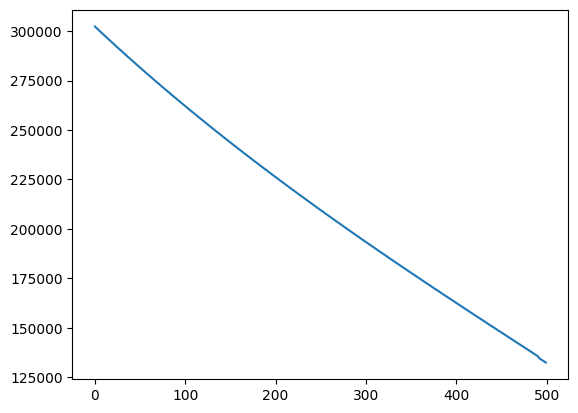

In [12]:
plt.plot(losses)

In [13]:
p = fgrm.sample(10)

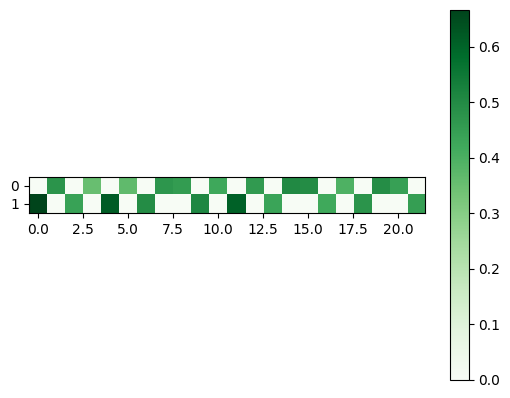

In [14]:
plt.imshow(p['discriminations'][0, 0, :, :, 0], cmap='Greens', vmin=0)
_ = plt.colorbar()